In [20]:
%load_ext autoreload
%autoreload 2

from Classes_and_functions import imports

from Classes_and_functions.Dataloader import load_datasets
from Classes_and_functions.Dataloader import load_real_datasets
from Classes_and_functions.Dataloader import functions

from Classes_and_functions.Model import model_classes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
writer = imports.SummaryWriter()

## Dataset

In [3]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [4]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [5]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 24005
Validation: 4000
Test: 4000


In [6]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [7]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


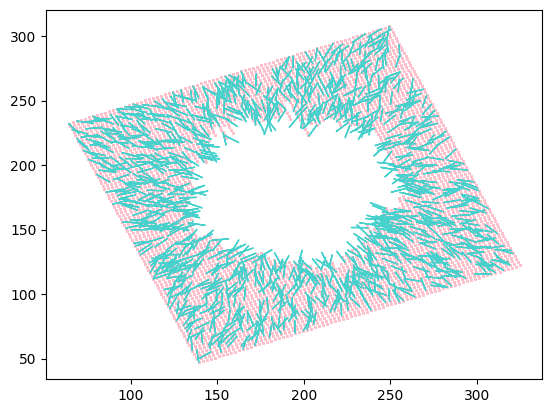

In [8]:
functions.plot_train_data(train_data)

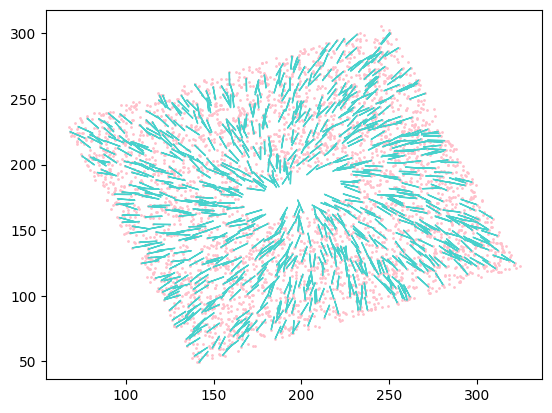

In [9]:
functions.plot_data(val_data)

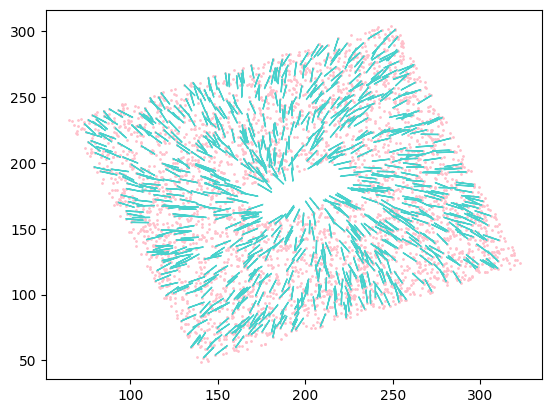

In [10]:
functions.plot_data(test_data)

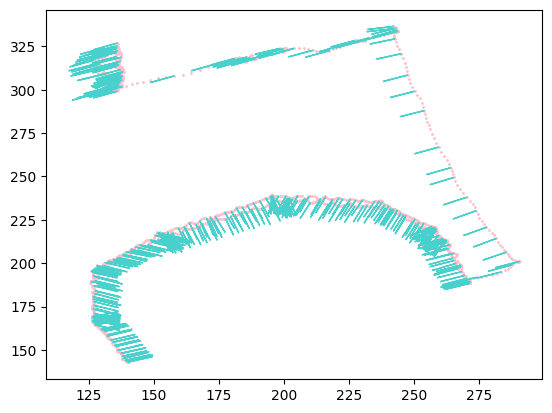

In [11]:
functions.plot_data(real_data)

In [12]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = imports.np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation pre filtering: 4000


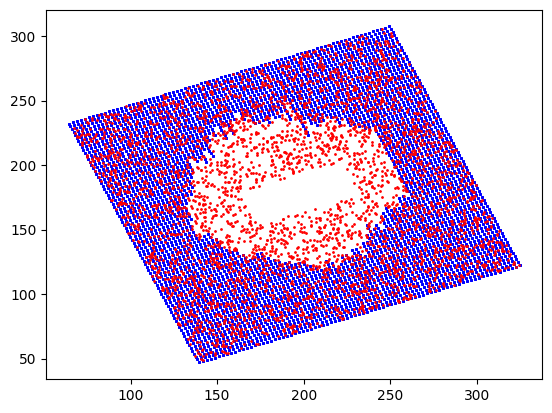

In [13]:
functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(val_data, "red")

print("Validation pre filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:02<00:00, 1818.51it/s]


Validation post filtering: 3253


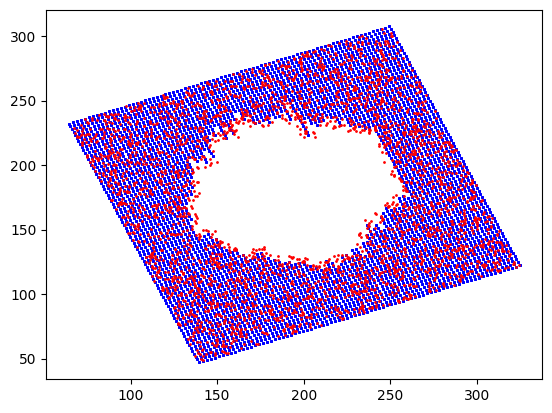

In [14]:
functions.filter_data(train_data, val_data)

functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(val_data, "red")

print("Validation post filtering: " + str(len(val_data.imgs)))

Test pre filtering: 4000


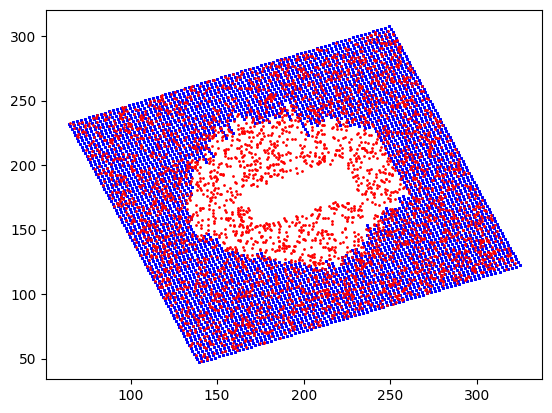

In [15]:
functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(test_data, "red")

print("Test pre filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:02<00:00, 1786.04it/s]


Test post filtering: 3271


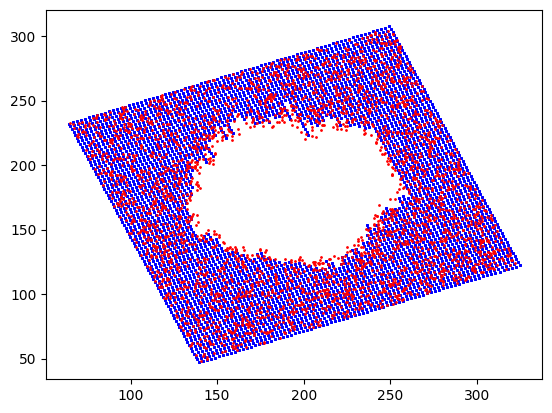

In [16]:
functions.filter_data(train_data, test_data)

functions.plot_synth_poses_train(train_data, "blue")
functions.plot_synth_poses_val(test_data, "red")

print("Test post filtering: " + str(len(test_data.imgs)))

iou: 0.9258700161948771
yaw difference tensor(5.4130) deg
localization error:  0.07804547 meters


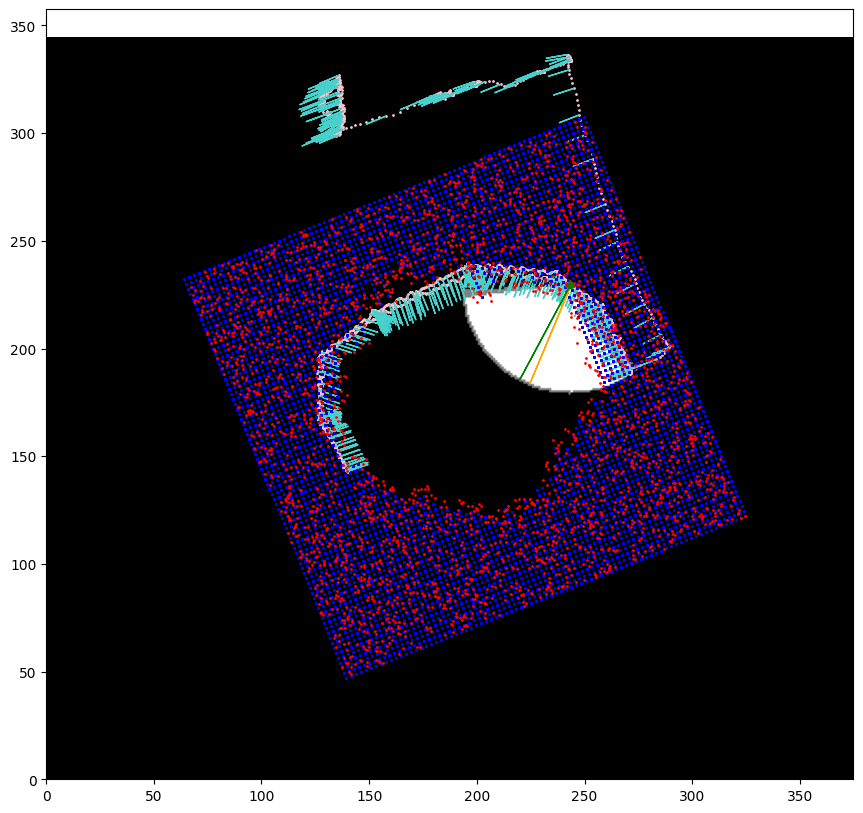

<Figure size 640x480 with 0 Axes>

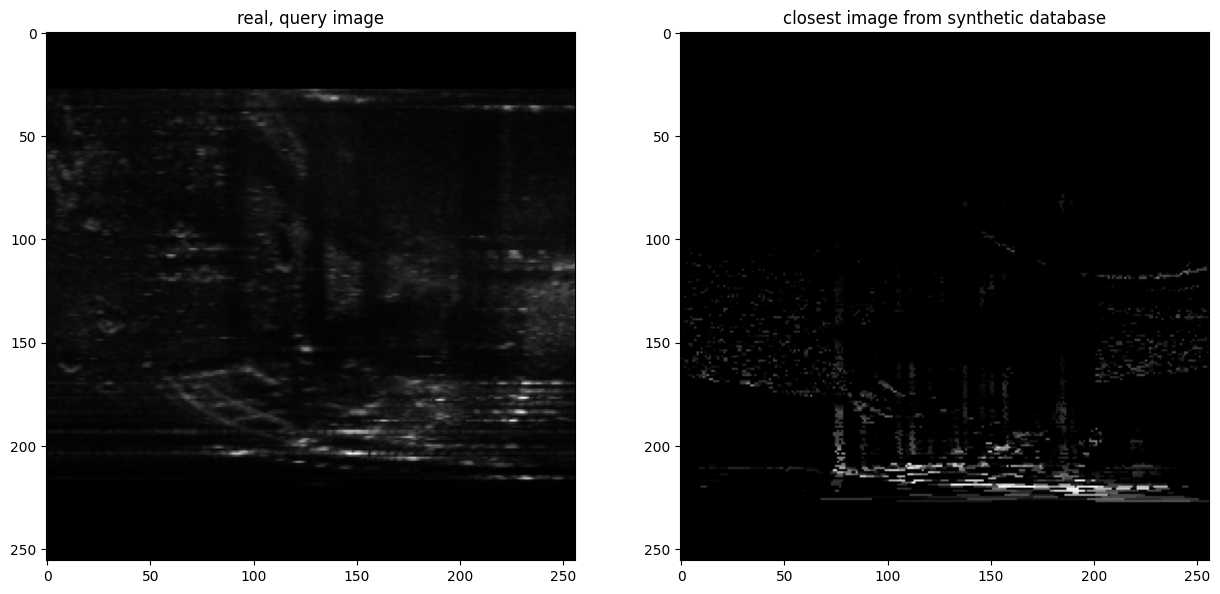

In [17]:
functions.localization(train_data, val_data, real_data)

In [18]:
batch = 16
train_dataloader = imports.DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [22]:
net = model_classes.Model().cuda()
net.train()

optimizer = imports.torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = imports.torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = imports.torch.nn.Dropout(0.3).cuda()

In [45]:
locacriterion = imports.torch.nn.CrossEntropyLoss().cuda()
recocriterion = imports.torch.nn.MSELoss().cuda()

## Training Pipeline

### Train epochs

In [21]:
for epoch in range(1, 25):

    ## train
    train_data.apply_random_rot = True
    net.train()

    train_losses = []

    for idx, (image, gtimage, gtpose, _, _, mode) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        image = drop(image.cuda())
        gtimage = gtimage.cuda()
        mode = mode[:, None].cuda()
        
        embed, rec = net(image, reco=True)

        distmat  = torch.clamp(sonar_overlap_distance_matrix(gtpose, mode), 1e-4, 1).cuda()
        embedmat = torch.clamp(calcEmbedMatrix(embed), 0, 1)

        distmat, embedmat = mode*distmat, mode*embedmat
        
        loss_reco = recocriterion(rec[0], gtimage) + 0.125*recocriterion(rec[3], gtimage) + 0.25*recocriterion(rec[4], gtimage)
        loss_loca = locacriterion(distmat, embedmat)
        loss = loss_reco + loss_loca
        writer.add_scalar(f"Loss/recotrain_{str(epoch).zfill(2)}", loss_reco.item(), idx)
        writer.add_scalar(f"Loss/locatrain_{str(epoch).zfill(2)}", loss_loca.item(), idx)
        writer.add_scalar(f"Loss/losstrain_{str(epoch).zfill(2)}", loss.item(), idx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())

        torch.cuda.empty_cache()

    print("train loss mean:", np.array(train_losses).mean())
    
    save_state(epoch, net, f"correct_model_3/epoch_{str(epoch).zfill(2)}.pth")

100%|███████████████████████████████████████| 1501/1501 [29:15<00:00,  1.17s/it]


train loss mean: 14.940069461376627


100%|███████████████████████████████████████| 1501/1501 [24:46<00:00,  1.01it/s]


train loss mean: 0.005393792429615028


100%|███████████████████████████████████████| 1501/1501 [24:52<00:00,  1.01it/s]


train loss mean: 0.003398243487092215


100%|███████████████████████████████████████| 1501/1501 [24:46<00:00,  1.01it/s]


train loss mean: 0.0029494593239176537


100%|███████████████████████████████████████| 1501/1501 [24:46<00:00,  1.01it/s]


train loss mean: 0.0028485054015892396


100%|███████████████████████████████████████| 1501/1501 [24:46<00:00,  1.01it/s]


train loss mean: 0.00283351778670113


100%|███████████████████████████████████████| 1501/1501 [24:46<00:00,  1.01it/s]


train loss mean: 0.004712708765326898


100%|███████████████████████████████████████| 1501/1501 [24:45<00:00,  1.01it/s]


train loss mean: 0.004954262306357794


100%|███████████████████████████████████████| 1501/1501 [24:44<00:00,  1.01it/s]


train loss mean: 0.005107813786999443


100%|███████████████████████████████████████| 1501/1501 [24:45<00:00,  1.01it/s]


train loss mean: 0.004689880798314558


100%|███████████████████████████████████████| 1501/1501 [24:44<00:00,  1.01it/s]


train loss mean: 0.005674605503824752


100%|███████████████████████████████████████| 1501/1501 [24:44<00:00,  1.01it/s]


train loss mean: 0.005315228239872023


100%|███████████████████████████████████████| 1501/1501 [25:10<00:00,  1.01s/it]


train loss mean: 0.005044147607092954


100%|███████████████████████████████████████| 1501/1501 [24:46<00:00,  1.01it/s]


train loss mean: 0.005064047595826062


100%|███████████████████████████████████████| 1501/1501 [24:44<00:00,  1.01it/s]


train loss mean: 71257.01947400058


100%|███████████████████████████████████████| 1501/1501 [24:50<00:00,  1.01it/s]


train loss mean: 0.5799309686372314


100%|███████████████████████████████████████| 1501/1501 [24:48<00:00,  1.01it/s]


train loss mean: 0.26354643585362647


100%|███████████████████████████████████████| 1501/1501 [24:44<00:00,  1.01it/s]


train loss mean: 0.136743937171673


100%|███████████████████████████████████████| 1501/1501 [24:43<00:00,  1.01it/s]


train loss mean: 0.066995683496571


100%|███████████████████████████████████████| 1501/1501 [24:44<00:00,  1.01it/s]


train loss mean: 0.03653611409056592


100%|███████████████████████████████████████| 1501/1501 [24:44<00:00,  1.01it/s]


train loss mean: 0.01876750860988677


100%|███████████████████████████████████████| 1501/1501 [24:45<00:00,  1.01it/s]


train loss mean: 0.008493553876856977


100%|███████████████████████████████████████| 1501/1501 [24:45<00:00,  1.01it/s]


train loss mean: 0.004670896159446513


100%|███████████████████████████████████████| 1501/1501 [24:44<00:00,  1.01it/s]

train loss mean: 0.0033365986516251216


In [22]:
with torch.no_grad():

    emb_size = 256
    
    # 1. build train images embeddings
    train_pred_embeds = torch.zeros((train_data.synth, emb_size))
    for idx in tqdm(range(train_data.synth)):
        image, _, _, _, _, _ = train_data[idx]
        image = image[None].cuda()
        descriptor = net(image, reco=False)[0, :].detach().cpu()
        train_pred_embeds[idx, :] = descriptor
    train_data.computeDescriptors(net)
    train_pred_embeds = torch.Tensor(train_data.descriptors)
    
    
    # 2. build val images embeddings
    val_data.computeDescriptors(net)
    val_pred_embeds = torch.Tensor(val_data.descriptors)
    
    gt_indices = val_data.closest_indices
    
    pred_indices      = correlate_poses_topk(val_pred_embeds, train_pred_embeds, k=1).squeeze()
    pred_indices_top5 = correlate_poses_topk(val_pred_embeds, train_pred_embeds, k=5)
    
    print(pred_indices.shape, pred_indices_top5.shape)
    
    avg_metric_e      = computeAverageMetricError(pred_indices,      gt_indices, train_data, k=1)
    avg_metric_e_top5 = computeAverageMetricError(pred_indices_top5, gt_indices, train_data, k=5)
    
    print("avg_metric_e     :", avg_metric_e)
    print("avg_metric_e_top5:", avg_metric_e_top5)

100%|█████████████████████████████████████| 24005/24005 [04:05<00:00, 97.81it/s]


computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:12<00:00, 94.91it/s]
/tmp/ipykernel_827315/3899127605.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_pred_embeds = torch.Tensor(train_data.descriptors)


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3253/3253 [00:40<00:00, 80.02it/s]


descriptors computed!
torch.Size([3253]) torch.Size([3253, 5])
avg_metric_e     : tensor(115.6565)
avg_metric_e_top5: tensor(66.4560)


In [23]:
with torch.no_grad():
    train_data.computeDescriptors(net)
    train_pred_embeds = torch.Tensor(train_data.descriptors)

computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:27<00:00, 89.82it/s]


descriptors computed!


In [24]:
train_pred_embeds = torch.Tensor(train_data.descriptors)

In [25]:
with torch.no_grad():

    # MODIFY by Andrea
    emb_size = 256
    
    # 2. build val images embeddings
    val_data.computeDescriptors(net)
    val_pred_embeds = torch.Tensor(val_data.descriptors)

computing dataset descriptors


100%|███████████████████████████████████████| 3253/3253 [00:39<00:00, 83.32it/s]


descriptors computed!


In [26]:
gt_indices = val_data.closest_indices

pred_indices      = correlate_poses_topk(val_pred_embeds, train_pred_embeds, k=1).squeeze()
pred_indices_top5 = correlate_poses_topk(val_pred_embeds, train_pred_embeds, k=5)

print(pred_indices.shape, pred_indices_top5.shape)

avg_metric_e      = computeAverageMetricError(pred_indices,      gt_indices, train_data, k=1)
avg_metric_e_top5 = computeAverageMetricError(pred_indices_top5, gt_indices, train_data, k=5)

print("avg_metric_e     :", avg_metric_e)
print("avg_metric_e_top5:", avg_metric_e_top5)

torch.Size([3253]) torch.Size([3253, 5])
avg_metric_e     : tensor(115.6565)
avg_metric_e_top5: tensor(66.4560)


## Visualize Training results on Validation data

### Load the checkpoint model

In [108]:
checkpoint_path = f"correct_model_3/epoch_24.pth"
net = Model()
load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [109]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:36<00:00, 86.82it/s]

descriptors computed!


In [112]:
val_data.computeDescriptors(net)

computing dataset descriptors


100%|███████████████████████████████████████| 3253/3253 [00:36<00:00, 89.50it/s]

descriptors computed!


### Visualize query results: sonar images

In [110]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-7.5603, device='cuda:0', grad_fn=<MinBackward1>) tensor(7.9702, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-43.4569, device='cuda:0', grad_fn=<MinBackward1>) tensor(45.3908, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-23.6651, device='cuda:0', grad_fn=<MinBackward1>) tensor(25.0087, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-12.7368, device='cuda:0', grad_fn=<MinBackward1>) tensor(15.7262, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5362, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4415, device='cuda:0', grad_fn=<MaxBackward1>)


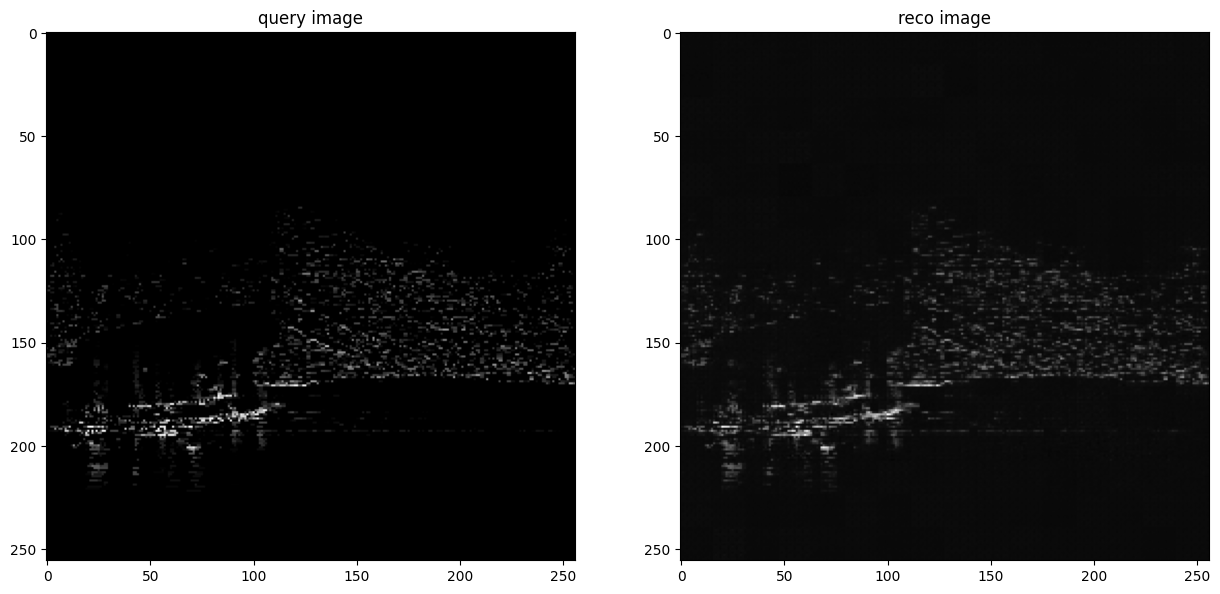

In [92]:
q_idx = 200
q_image_a, q_image, q_pose, _, _, _ = train_data[q_idx]
q_image_a = q_image_a[None].cuda()

out = net.encoder(q_image_a)
print(out[0].shape, out[0].min(), out[0].max())
print(out[1].shape, out[1].min(), out[1].max())
print(out[2].shape, out[2].min(), out[2].max())
print(out[3].shape, out[3].min(), out[3].max())
out[2][0, :, :, :] = out[2][0, :, :, :] + torch.normal(0, 3, size=out[2][:, :, :, :].shape).cuda()
out[2][0, :, :, :] = out[2][0, :, :, :] + torch.normal(0, 3, size=out[2][:, :, :, :].shape).cuda()
out[3][0, :, :, :] = 0
q_desc = torch.nn.functional.normalize(net.embed(out[-1]).flatten(1), p=2, dim=1)
q_image_r = net.decoder(out)[0]

print(q_image_r[0].min(), q_image_r[0].max())

f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].set_title("query image")
axarr[1].set_title("reco image")

axarr[0].imshow(q_image.detach().cpu().numpy()[0, :, :], cmap='gray')
axarr[1].imshow(q_image_r.detach().cpu().numpy()[0, 0, :, :], cmap='gray')

pos tensor([1.2119, 1.2119, 1.2119, 1.2119, 1.2119])
diff_yaw tensor([ 93.1999, 138.1999, 123.1999,  78.1999, 108.1999])
min_yaw_idx tensor(3)
GT degree: 260.658935546875, query degree: 248.85879516601562
iou: 0.0
localization error: 8.9617 meters
orientation error : 20.6764 degrees


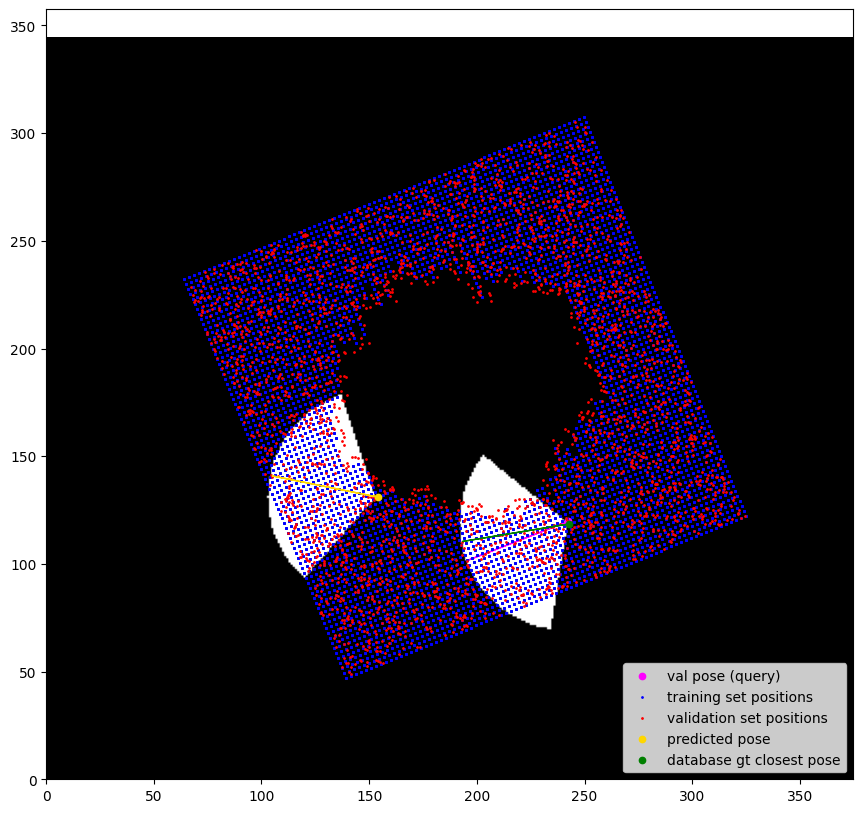

<Figure size 640x480 with 0 Axes>

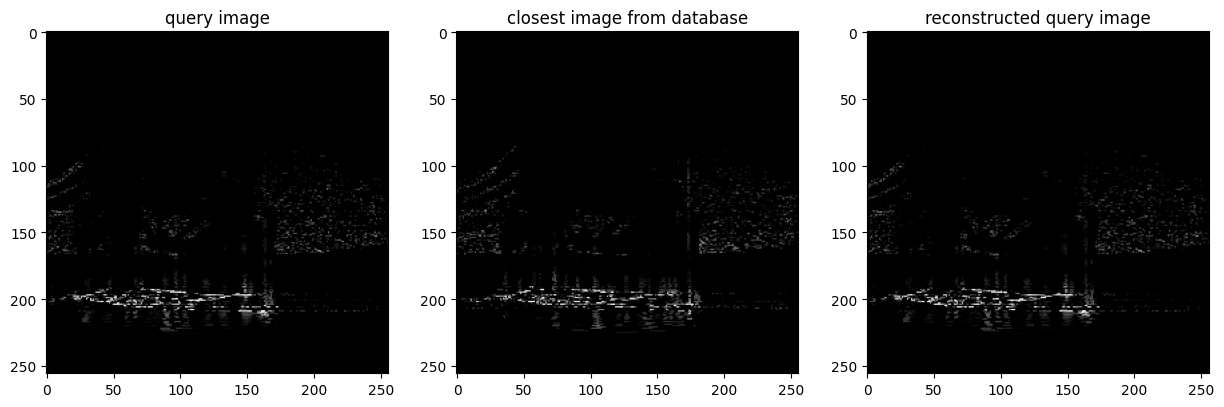

In [153]:
query_idx = random.randint(0, len(val_data))

loca_error, orie_error = process(query_idx, net, train_data, val_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [154]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(val_data))):
    loca_error, orie_error = process(query_idx, net, train_data, val_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

100%|███████████████████████████████████████| 3253/3253 [06:47<00:00,  7.98it/s]

average localization error: 11.3971 meters
average orientation error : 87.9146 degrees


In [155]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [156]:
loca_errors.argmax()

np.int64(3014)

In [157]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

5.452863
40.0321


## Visualize Training results on Test data

### Load the checkpoint model

In [50]:
checkpoint_path = f"correct_model_3/epoch_24.pth"
net = Model()
load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [ ]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

### Visualize query results: sonar images

In [51]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-7.5603, device='cuda:0', grad_fn=<MinBackward1>) tensor(7.9702, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-43.4569, device='cuda:0', grad_fn=<MinBackward1>) tensor(45.3908, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-23.6651, device='cuda:0', grad_fn=<MinBackward1>) tensor(25.0087, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-12.7368, device='cuda:0', grad_fn=<MinBackward1>) tensor(15.7262, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5394, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4474, device='cuda:0', grad_fn=<MaxBackward1>)


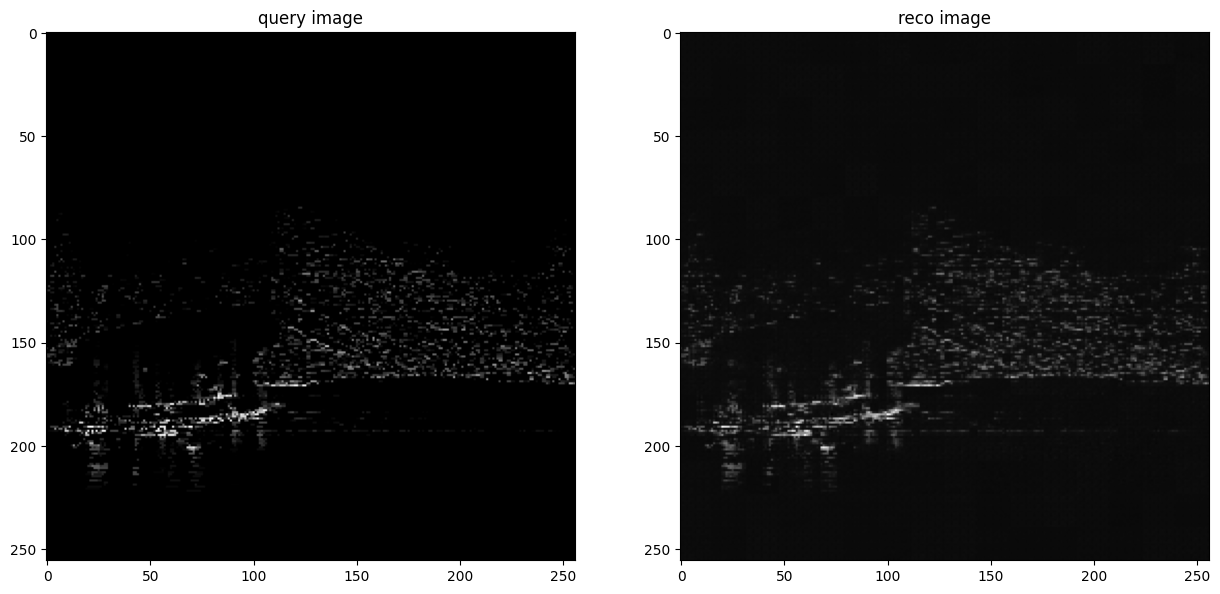

In [52]:
q_idx = 200
q_image_a, q_image, q_pose, _, _, _ = train_data[q_idx]
q_image_a = q_image_a[None].cuda()

out = net.encoder(q_image_a)
print(out[0].shape, out[0].min(), out[0].max())
print(out[1].shape, out[1].min(), out[1].max())
print(out[2].shape, out[2].min(), out[2].max())
print(out[3].shape, out[3].min(), out[3].max())
out[2][0, :, :, :] = out[2][0, :, :, :] + torch.normal(0, 3, size=out[2][:, :, :, :].shape).cuda()
out[2][0, :, :, :] = out[2][0, :, :, :] + torch.normal(0, 3, size=out[2][:, :, :, :].shape).cuda()
out[3][0, :, :, :] = 0
q_desc = torch.nn.functional.normalize(net.embed(out[-1]).flatten(1), p=2, dim=1)
q_image_r = net.decoder(out)[0]

print(q_image_r[0].min(), q_image_r[0].max())

f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].set_title("query image")
axarr[1].set_title("reco image")

axarr[0].imshow(q_image.detach().cpu().numpy()[0, :, :], cmap='gray')
axarr[1].imshow(q_image_r.detach().cpu().numpy()[0, 0, :, :], cmap='gray')

0.36432647705078125
iou: 1.0
localization error: 0.1499 meters
orientation error : 0.3643 degrees


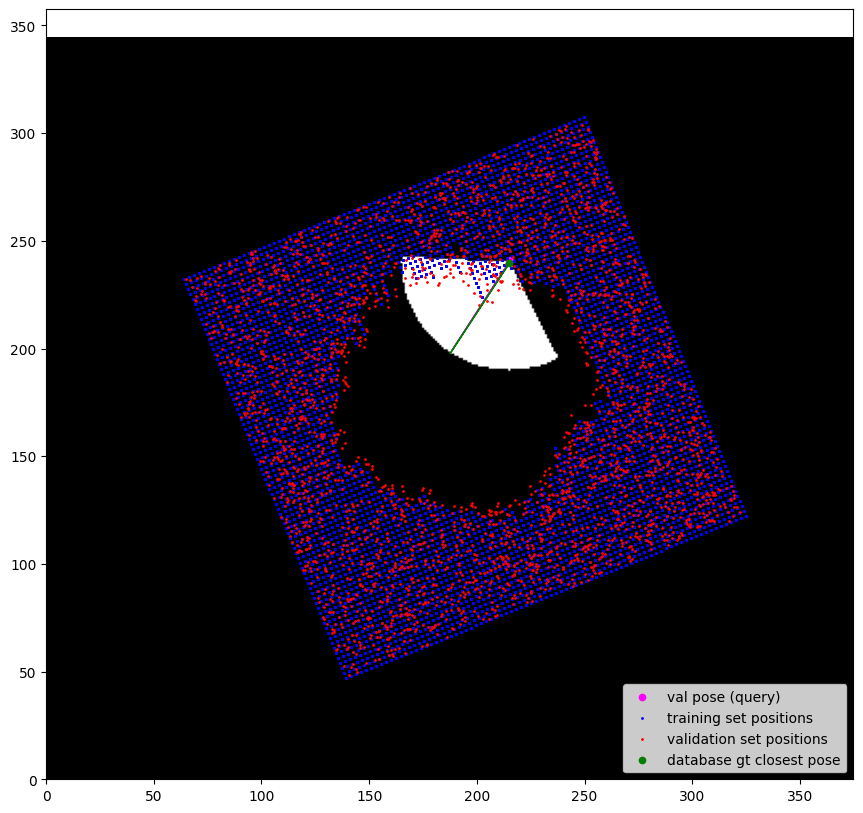

<Figure size 640x480 with 0 Axes>

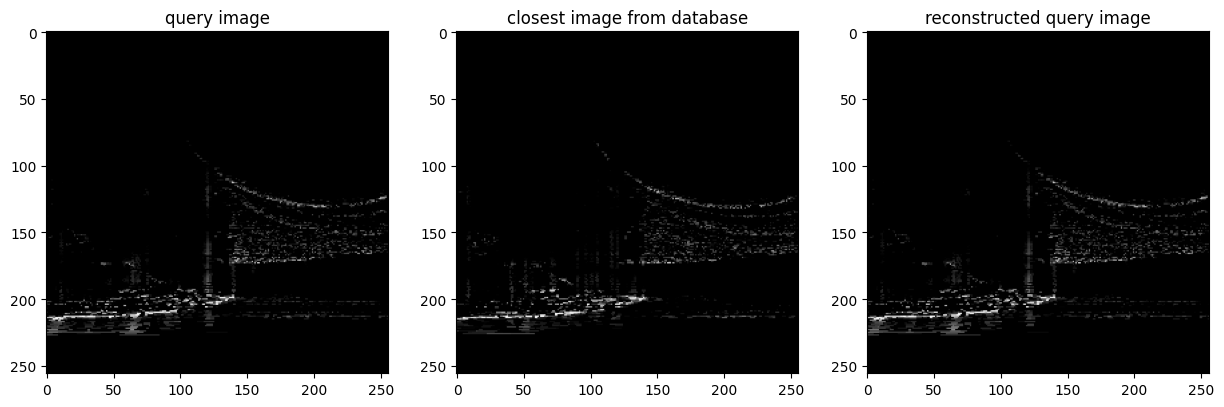

In [53]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [54]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

  0%|                                          | 2/3271 [00:00<04:52, 11.18it/s]

26.352767944335938
19.234859466552734
2.2108497619628906
-31.946578979492188
-24.611602783203125


  0%|                                          | 7/3271 [00:00<01:55, 28.29it/s]

10.18896484375
-41.62472152709961
-40.71586608886719
-34.176300048828125
6.2690582275390625


  0%|▏                                        | 15/3271 [00:00<02:22, 22.81it/s]

-35.134033203125
26.134368896484375
-8.046844482421875
-4.515380859375
-15.342086791992188


  1%|▎                                        | 20/3271 [00:00<01:54, 28.34it/s]

7.683906555175781
-40.60857391357422
25.338790893554688
5.135494232177734
-1.7965354919433594


  1%|▎                                        | 24/3271 [00:00<02:05, 25.92it/s]

-54.84074401855469
-14.834419250488281
-49.06873321533203
26.444244384765625
355.15391540527344
-10.3021240234375
-35.504329681396484


  1%|▍                                        | 34/3271 [00:01<01:46, 30.40it/s]

-48.89543914794922
-10.008987426757812
13.78179056942463
24.433853149414062
-16.956148147583008
-11.728897094726562
-38.91986083984375


  1%|▍                                        | 38/3271 [00:01<01:57, 27.53it/s]

-41.7515869140625
8.193756103515625
-1.974212646484375
14.816814422607422
-26.63332748413086
21.15707778930664


  1%|▌                                        | 42/3271 [00:01<02:06, 25.53it/s]

13.08028793334961
-38.31606864929199
-17.903160095214844
-16.993072509765625
-31.173751831054688
29.99493408203125
14.009625434875488


  2%|▋                                        | 54/3271 [00:01<01:39, 32.18it/s]

-28.006072998046875
11.102264404296875
-3.4674301147460938
-54.97126770019531
-8.153190612792969
-45.48170471191406
-0.9746799468994141


  2%|▋                                        | 58/3271 [00:02<01:51, 28.73it/s]

13.583328247070312
-51.70173645019531
-10.189315795898438
-2.086193084716797
-42.72578430175781
-38.93887519836426


  2%|▊                                        | 66/3271 [00:02<01:54, 28.05it/s]

-37.43257713317871
0.4253120422363281
-43.050132751464844
5.7440948486328125
-53.70646667480469
-40.94475555419922


  2%|▉                                        | 70/3271 [00:02<02:06, 25.35it/s]

-15.94088363647461
-16.656021118164062
-25.149425506591797
11.508056640625
11.538759231567383
-51.03057861328125
-4.137119293212891


  2%|▉                                        | 79/3271 [00:02<01:52, 28.35it/s]

23.527603149414062
1.6553764343261719
-57.588653564453125
-29.294876098632812
6.34698486328125
-7.386932373046875


  3%|█                                        | 83/3271 [00:03<02:30, 21.22it/s]

-6.760040283203125
-1.015289306640625
-8.153797149658203
3.5843276977539062


  3%|█                                        | 86/3271 [00:03<02:43, 19.44it/s]

10.744216918945312
-17.523067474365234
-35.984249114990234
23.528457641601562


  3%|█▏                                       | 90/3271 [00:03<02:18, 22.97it/s]

9.971500396728516
10.586868286132812
12.829864501953125
310.2852439880371
312.712833404541


  3%|█▏                                       | 98/3271 [00:03<02:08, 24.62it/s]

-0.22178268432617188
-7.848079681396484
0.773430347442627
-25.66836166381836
-5.271811842918396
-46.47181701660156


  3%|█▏                                      | 101/3271 [00:04<02:23, 22.13it/s]

-12.8243408203125
17.379249572753906
-9.005325317382812
-16.97467041015625
314.8164596557617
7.362142562866211


  3%|█▎                                      | 111/3271 [00:04<01:48, 29.11it/s]

-12.789192199707031
-45.246063232421875
9.611803531646729
3.0950775146484375
-34.169830322265625
-3.7631301879882812
-43.90718078613281


  4%|█▍                                      | 115/3271 [00:04<01:57, 26.94it/s]

19.395225524902344
-28.079660415649414
-44.9716796875
-23.883913040161133
3.0196571350097656
-20.99080467224121


  4%|█▍                                      | 119/3271 [00:04<02:03, 25.48it/s]

-54.82042217254639
-57.792118072509766
-30.411712646484375
-51.81739807128906
-21.81201934814453
-9.688117980957031


  4%|█▌                                      | 130/3271 [00:05<01:38, 31.77it/s]

-22.807876586914062
-13.717605590820312
-26.25261688232422
-34.71685028076172
-13.56202507019043
12.468107223510742
-41.0283203125


  4%|█▋                                      | 134/3271 [00:05<01:50, 28.38it/s]

-0.6511993408203125
-40.78857421875
-33.05135750770569
-27.56538200378418
2.9744796752929688
3.5341644287109375


  4%|█▋                                      | 138/3271 [00:05<01:57, 26.59it/s]

2.9746856689453125
-27.919036865234375
-8.08966064453125
-22.927146911621094
3.4386024475097656
-12.128952026367188


  5%|█▊                                      | 149/3271 [00:05<01:36, 32.28it/s]

0.39581298828125
-28.630481719970703
-0.2621612548828125
-7.326786041259766
14.600555419921875
14.743728637695312
-2.0701446533203125


  5%|█▊                                      | 153/3271 [00:05<01:47, 29.08it/s]

-10.045822143554688
10.870124816894531
-10.728710174560547
-26.064815521240234
4.8836822509765625
1.8914031982421875
302.08415603637695


  5%|█▉                                      | 162/3271 [00:06<01:55, 26.87it/s]

0.36432647705078125
-13.12847900390625
9.794849395751953
-2.8550491333007812
-4.593536376953125
22.569141387939453


  5%|██                                      | 168/3271 [00:06<01:32, 33.38it/s]

-43.23426818847656
17.221324920654297
8.375131607055664
-35.96824264526367
-9.828521728515625
-11.898092269897461


  5%|██                                      | 172/3271 [00:06<01:43, 29.99it/s]

-35.90419006347656
-10.38922119140625
23.417861938476562
-16.70473289489746
2.26763916015625
29.347686767578125


  5%|██▏                                     | 176/3271 [00:06<01:53, 27.28it/s]

-7.612174987792969
-0.250823974609375
-41.5355224609375
-355.67430877685547
0.7189788818359375
-50.16221618652344


  6%|██▎                                     | 187/3271 [00:06<01:33, 33.08it/s]

-35.4300537109375
-22.075096130371094
-37.208740234375
-44.242401123046875
-38.978477478027344
-2.9172897338867188
10.633476257324219


  6%|██▎                                     | 191/3271 [00:07<01:42, 29.98it/s]

-16.524391174316406
17.106821060180664
-4.407325744628906
4.9124298095703125
-33.95250701904297
318.0933647155762


  6%|██▍                                     | 195/3271 [00:07<01:50, 27.85it/s]

3.5218887329101562
-51.544952392578125
-26.488239288330078
301.2662162780762
-32.224884033203125
-44.58716583251953


  6%|██▌                                     | 206/3271 [00:07<01:31, 33.63it/s]

11.894903182983398
17.58917999267578
-42.50559663772583
-17.024253845214844
-3.5163116455078125
-30.952293395996094
-26.328144073486328


  6%|██▌                                     | 210/3271 [00:07<01:42, 29.88it/s]

-25.239501953125
-12.610275268554688
-2.8532562255859375
-51.39556121826172
21.192176818847656
-10.7174072265625


  7%|██▌                                     | 214/3271 [00:08<01:53, 26.86it/s]

28.84454345703125
4.319879531860352
12.580795288085938
-48.08904266357422
-8.637794494628906
-22.08599090576172


  7%|██▊                                     | 225/3271 [00:08<01:33, 32.63it/s]

-14.658355712890625
16.092041015625
-39.99105453491211
-8.637786865234375
-2.4454498291015625
1.0620079040527344
21.10986328125


  7%|██▊                                     | 229/3271 [00:08<01:42, 29.66it/s]

5.041851043701172
-26.392044067382812
-24.43360137939453
-55.231550216674805
-12.355342864990234
8.626785278320312


  7%|██▊                                     | 233/3271 [00:08<01:50, 27.49it/s]

-1.6968994140625
-18.092178344726562
28.5451078414917
-13.949615478515625
-26.351654052734375
-34.7733154296875


  7%|██▉                                     | 244/3271 [00:08<01:31, 33.04it/s]

-42.05973434448242
-2.6566925048828125
10.490554809570312
-7.9870147705078125
-24.947914123535156
27.177974700927734
-5.247917175292969


  8%|███                                     | 248/3271 [00:09<01:41, 29.76it/s]

-42.32929611206055
-0.3672637939453125
-45.91078186035156
-27.075035095214844
-36.93382263183594
-0.6119003295898438


  8%|███                                     | 252/3271 [00:09<01:49, 27.60it/s]

-25.717849731445312
307.6329917907715
-3.7036666870117188
335.722900390625
-9.513343811035156
-19.148834228515625


  8%|███▏                                    | 263/3271 [00:09<01:29, 33.63it/s]

-14.700035095214844
-24.580337524414062
-11.768165588378906
27.93769073486328
28.97174072265625
-34.356937408447266
-12.650436401367188


  8%|███▎                                    | 267/3271 [00:09<01:39, 30.16it/s]

-19.403656005859375
11.939117431640625
3.221221923828125
-57.31196594238281
-42.24949645996094
-41.761688232421875


  8%|███▎                                    | 271/3271 [00:09<01:47, 28.03it/s]

-341.75732421875
18.1029052734375
13.039552688598633
12.268867492675781
-21.172969818115234
19.440261840820312


  9%|███▍                                    | 282/3271 [00:10<01:28, 33.74it/s]

-36.49803161621094
-2.8336181640625
5.7927703857421875
-50.63848876953125
-10.180005073547363
-24.22205352783203
19.844017028808594


  9%|███▍                                    | 286/3271 [00:10<01:38, 30.41it/s]

-11.584115028381348
-32.521705627441406
3.0951690673828125
15.82940673828125
-10.143829345703125
-17.603256225585938


  9%|███▌                                    | 293/3271 [00:10<02:01, 24.60it/s]

-12.339370727539062
-21.009380340576172
-34.64576721191406
1.018463134765625
-32.207000732421875


  9%|███▌                                    | 296/3271 [00:10<02:24, 20.52it/s]

3.6104049682617188
-27.61257553100586
-15.200551986694336


  9%|███▋                                    | 299/3271 [00:11<02:23, 20.64it/s]

0.2827301025390625
-19.21881103515625
-47.35284423828125
-33.540496826171875
-3.9856910705566406


  9%|███▋                                    | 302/3271 [00:11<03:03, 16.16it/s]

-12.256210327148438
2.1504440307617188
10.5941162109375
-48.24683380126953
-19.605613708496094
12.419502258300781


 10%|███▊                                    | 313/3271 [00:11<02:02, 24.09it/s]

5.364692687988281
-5.817596435546875
1.4367218017578125
-28.51079559326172
-42.07550048828125
-37.8032341003418


 10%|███▊                                    | 316/3271 [00:11<02:11, 22.53it/s]

-34.10626220703125
-33.143165588378906
15.177505493164062
336.22764587402344
-33.211891651153564
5.427452087402344
-43.05217885971069


 10%|███▉                                    | 326/3271 [00:12<01:50, 26.58it/s]

-54.61878776550293
-15.941482543945312
14.979194641113281
-0.203857421875
-16.663881301879883
-7.600944519042969


 10%|████                                    | 329/3271 [00:12<02:05, 23.46it/s]

-27.869308471679688
-34.63096618652344
14.557830810546875
-52.17131805419922
3.8361473083496094
0.36376953125


 10%|████                                    | 333/3271 [00:12<02:13, 21.96it/s]

343.9823989868164
0.2945365905761719
-45.399932861328125


 10%|████                                    | 336/3271 [00:12<02:31, 19.39it/s]

-2.3416595458984375
9.432323455810547
-16.452789306640625


 10%|████▏                                   | 341/3271 [00:13<03:10, 15.35it/s]

1.8543243408203125
-15.627891540527344
-34.50117874145508


 11%|████▏                                   | 345/3271 [00:13<02:35, 18.85it/s]

-12.421951293945312
12.963470458984375
-10.541427612304688
-4.489479064941406


 11%|████▎                                   | 348/3271 [00:13<02:51, 17.03it/s]

29.02212142944336
-28.858673095703125
-43.13134765625
-11.573047637939453
-44.97218322753906
-22.28045654296875


 11%|████▍                                   | 358/3271 [00:13<01:53, 25.56it/s]

-26.14232635498047
-1.8744049072265625
-21.949691772460938
0.7934646606445312
29.363170623779297
-47.15785217285156
-17.702865600585938


 11%|████▍                                   | 361/3271 [00:14<02:16, 21.27it/s]

-37.439120292663574
-18.949615478515625
-20.373855590820312
-44.827850341796875
-59.922027587890625
4.583320617675781


 11%|████▌                                   | 368/3271 [00:14<02:09, 22.43it/s]

-4.7969970703125
12.78591537475586
23.03360366821289
20.04944610595703
-11.439010620117188
17.00816535949707


 11%|████▌                                   | 375/3271 [00:14<02:01, 23.87it/s]

-26.465593338012695
14.057235717773438
319.57198333740234
22.654708862304688
-41.56053161621094
-36.83119201660156
-33.13055419921875


 12%|████▌                                   | 378/3271 [00:15<02:48, 17.13it/s]

-42.22169494628906
-44.21379089355469


 12%|████▋                                   | 384/3271 [00:15<03:30, 13.73it/s]

22.841049194335938
-27.169612884521484
-34.639320373535156
-39.66792297363281
-53.339454650878906


 12%|████▊                                   | 389/3271 [00:15<02:30, 19.14it/s]

-25.355880737304688
-36.7391881942749
-8.078987121582031
-31.811325073242188
12.422592163085938


 12%|████▊                                   | 392/3271 [00:15<02:33, 18.73it/s]

-337.6868438720703
-49.24705505371094
335.58355712890625
-40.234893798828125
2.03948974609375
-2.2198486328125
337.09886932373047


 12%|████▊                                   | 397/3271 [00:16<02:17, 20.88it/s]

-28.121292114257812
314.11878967285156
-55.76356506347656
10.923797607421875
-12.713516235351562
345.28021240234375


 12%|████▉                                   | 403/3271 [00:16<02:03, 23.20it/s]

-15.352851867675781
-11.048995971679688
-37.494171142578125
-29.293502807617188
29.549318313598633
26.93186330795288


 13%|█████                                   | 415/3271 [00:16<01:35, 30.05it/s]

-31.352806091308594
-10.349166870117188
2.4061279296875
3.9832382202148438
4.359920501708984
-2.8522605895996094
15.832489013671875


 13%|█████                                   | 419/3271 [00:16<01:51, 25.61it/s]

8.711524963378906
-20.91625213623047
6.207275390625
-30.11603546142578
-36.7464599609375
-24.96092987060547


 13%|█████▏                                  | 422/3271 [00:17<02:17, 20.68it/s]

350.4747009277344
-14.300132751464844
-33.22630310058594
-35.136444091796875
-42.67250442504883
-37.054840087890625


 13%|█████▎                                  | 433/3271 [00:17<01:47, 26.48it/s]

-4.44708251953125
8.530563354492188
-5.071632385253906
9.221527099609375
4.3157196044921875
-5.04081916809082
-31.903793334960938


 13%|█████▎                                  | 437/3271 [00:17<01:54, 24.67it/s]

-18.09210205078125
-13.535209655761719
-53.763397216796875
17.285858154296875
-53.78651142120361
-30.913230895996094


 13%|█████▍                                  | 441/3271 [00:17<02:02, 23.06it/s]

-346.7179641723633
-41.72505187988281
18.212020874023438
-29.387075424194336
-39.057518005371094
-58.98005676269531


 14%|█████▌                                  | 453/3271 [00:18<01:35, 29.47it/s]

14.55291748046875
-10.221622467041016
-35.85614776611328
-40.13542175292969
10.703585147857666
-22.291358947753906
-29.660614013671875


 14%|█████▌                                  | 457/3271 [00:18<01:49, 25.70it/s]

-13.632728576660156
-0.5226974487304688
-35.82948303222656
326.91114807128906
-31.264312744140625
13.410491943359375


 14%|█████▋                                  | 460/3271 [00:18<01:57, 24.01it/s]

8.233642578125
-20.125259399414062
-17.629180908203125
-54.78778076171875
-8.457748413085938
2.2540740966796875


 14%|█████▊                                  | 472/3271 [00:18<01:28, 31.66it/s]

-17.096633911132812
-42.044219970703125
-10.799896240234375
-27.850677490234375
9.586280822753906
5.313728332519531
331.4069061279297


 15%|█████▊                                  | 476/3271 [00:19<01:36, 29.10it/s]

-9.257465362548828
-54.43061065673828
9.622228622436523
-28.82156753540039
-42.4228401184082
-3.6861572265625


 15%|█████▊                                  | 480/3271 [00:19<01:41, 27.44it/s]

334.8815460205078
-2.245819091796875
-48.72187805175781
1.0890121459960938
-2.25921630859375
1.1347312927246094


 15%|██████                                  | 491/3271 [00:19<01:23, 33.35it/s]

-39.66394805908203
0.4666786193847656
305.4046936035156
-18.441937744617462
-34.399864196777344
12.1640625
-23.147613525390625


 15%|██████                                  | 495/3271 [00:19<01:32, 30.17it/s]

317.2011375427246
-10.61141586303711
6.647228240966797
-44.26220488548279
-15.623001098632812
-42.63584899902344


 15%|██████                                  | 499/3271 [00:19<01:39, 27.78it/s]

-24.694286346435547
-38.1326904296875
-44.94279479980469
-28.04447364807129
-36.83587646484375
-56.74664306640625


 16%|██████▏                                 | 510/3271 [00:20<01:21, 33.75it/s]

-21.601287841796875
-46.48113250732422
-12.863433837890625
309.35203552246094
-35.7259726524353
13.470280647277832
3.629974365234375


 16%|██████▎                                 | 514/3271 [00:20<01:31, 30.26it/s]

-30.93390655517578
12.530595779418945
8.802017211914062
-36.320465087890625
-16.877315521240234
-15.506904602050781


 16%|██████▎                                 | 518/3271 [00:20<01:38, 28.04it/s]

-57.06745910644531
6.586193084716797
-11.27947998046875
321.66149139404297
17.173751831054688
11.103668212890625


 16%|██████▍                                 | 529/3271 [00:20<01:20, 33.99it/s]

-33.335567474365234
-42.325626373291016
7.4277801513671875
-33.82344055175781
-351.09999084472656
1.111602783203125
-54.59200668334961


 16%|██████▌                                 | 533/3271 [00:20<01:30, 30.30it/s]

27.6602201461792
343.6352996826172
-18.897071838378906
-50.01939392089844
-43.24560546875
-9.893856048583984


 16%|██████▌                                 | 537/3271 [00:21<01:37, 28.12it/s]

-6.588249206542969
-34.36482620239258
-2.8148880004882812
-47.83952713012695
-48.044151306152344
-36.496246337890625


 17%|██████▋                                 | 548/3271 [00:21<01:20, 33.87it/s]

8.56134033203125
-28.46703338623047
-341.431884765625
-31.66696548461914
-54.982913970947266
-23.314559936523438
-23.924089431762695


 17%|██████▊                                 | 552/3271 [00:21<01:29, 30.47it/s]

22.413772583007812
9.648956298828125
-10.726547241210938
10.760272979736328
-8.353706359863281
15.307815551757812
12.84762191772461


 17%|██████▊                                 | 561/3271 [00:21<01:38, 27.49it/s]

-14.582332849502563
-34.024606704711914
-20.50065040588379
-34.89518737792969
8.190673828125
-9.555885314941406


 17%|██████▉                                 | 567/3271 [00:22<01:20, 33.59it/s]

-23.314876556396484
-55.25988006591797
-31.99211883544922
-33.544898986816406
-31.477951049804688
-352.78987884521484


 17%|██████▉                                 | 571/3271 [00:22<01:28, 30.38it/s]

1.5368194580078125
-60.257667541503906
-50.03015899658203
-30.36156463623047
22.576492309570312
-53.62651443481445


 18%|███████                                 | 575/3271 [00:22<01:35, 28.20it/s]

-30.053421020507812
-37.77882385253906
-43.839141845703125
3.9934234619140625
-35.876953125
14.894317626953125


 18%|███████▏                                | 586/3271 [00:22<01:18, 34.16it/s]

-1.988189697265625
-26.872894287109375
-7.470813751220703
-40.6380500793457
28.405517578125
8.424259185791016
6.302787780761719


 18%|███████▏                                | 590/3271 [00:22<01:28, 30.41it/s]

2.49163818359375
-36.551361083984375
-59.67253875732422
-3.7988967895507812
7.255912780761719
-23.052749633789062


 18%|███████▎                                | 594/3271 [00:23<01:35, 27.91it/s]

-35.0152587890625
-25.2520751953125
-7.0587615966796875
-46.9710693359375
22.06561279296875
9.751462936401367


 18%|███████▍                                | 605/3271 [00:23<01:19, 33.66it/s]

14.337448120117188
-41.54294204711914
-28.564590454101562
-24.484390258789062
-28.33099365234375
28.174270629882812
1.0817947387695312


 19%|███████▍                                | 609/3271 [00:23<01:27, 30.35it/s]

13.02011489868164
-27.236373901367188
11.859786987304688
26.52020263671875
-5.638038635253906
-28.018966674804688
320.84227752685547


 19%|███████▌                                | 618/3271 [00:23<01:35, 27.73it/s]

9.026939392089844
-31.45656156539917
-27.656688690185547
-31.72275996208191
3.1947364807128906
-31.065460205078125


 19%|███████▋                                | 624/3271 [00:23<01:17, 34.12it/s]

-29.707504272460938
23.6485595703125
-0.2120361328125
-46.77250671386719
-57.3981819152832
23.932281494140625
-34.1392822265625


 19%|███████▋                                | 628/3271 [00:24<01:26, 30.58it/s]

12.72060775756836
-24.123836517333984
25.375892639160156
14.565681457519531
11.302356719970703
-48.97782897949219


 19%|███████▊                                | 637/3271 [00:24<01:35, 27.72it/s]

26.52978515625
-11.532394409179688
-43.58876037597656
-5.9998779296875
-42.04937553405762
-14.057861328125


 20%|███████▊                                | 643/3271 [00:24<01:17, 34.08it/s]

12.422560691833496
-16.026363372802734
10.960121154785156
12.539433479309082
18.944549560546875
-22.247314453125


 20%|███████▉                                | 647/3271 [00:24<01:25, 30.55it/s]

-56.90144348144531
12.460884094238281
320.7433624267578
-12.879138946533203
5.538555145263672
0.7512550354003906


 20%|███████▉                                | 651/3271 [00:24<01:33, 28.12it/s]

-10.1719970703125
-13.439559936523438
-8.12908935546875
-45.61634826660156
6.9775848388671875
-9.175281524658203


 20%|████████                                | 656/3271 [00:25<01:34, 27.68it/s]

-37.0250244140625
-42.68663024902344
-36.5604248046875
315.76638412475586
-20.36658477783203
-34.451988220214844
-36.02000427246094


 20%|████████                                | 663/3271 [00:25<01:29, 29.20it/s]

-22.70403289794922
-22.06631851196289
-32.026798248291016
-35.36144256591797
15.455154418945312
-10.253292083740234


 20%|████████▏                               | 669/3271 [00:25<01:28, 29.24it/s]

-6.171442270278931
-24.558990478515625
313.8175582885742
1.5355682373046875
25.01043701171875
-51.02308654785156


 21%|████████▎                               | 681/3271 [00:25<01:14, 34.63it/s]

9.022956848144531
5.148216247558594
-28.88905906677246
-23.053054809570312
-42.44812774658203
-18.223556518554688
-21.822372436523438


 21%|████████▍                               | 685/3271 [00:26<01:22, 31.22it/s]

-5.417633056640625
-20.978614807128906
-17.436126708984375
-36.57955551147461
-24.326942443847656
-10.774490356445312


 21%|████████▍                               | 689/3271 [00:26<01:29, 28.93it/s]

-37.872589111328125
-49.64337158203125
18.19486427307129
-18.567241668701172
-35.326637268066406
-37.28521728515625


 21%|████████▌                               | 700/3271 [00:26<01:14, 34.42it/s]

-35.57156562805176
-44.16375732421875
-56.57281494140625
-28.2183837890625
10.137950897216797
5.670845031738281
-40.57670593261719


 22%|████████▌                               | 704/3271 [00:26<01:22, 31.01it/s]

20.481582641601562
-12.46157455444336
-8.147186279296875
-0.26706695556640625
14.201446533203125
1.2836694717407227
-15.503536224365234


 22%|████████▋                               | 713/3271 [00:27<01:31, 28.03it/s]

-14.937999248504639
29.08087158203125
23.910049438476562
-11.211929321289062
9.662750244140625
-32.33509063720703


 22%|████████▊                               | 719/3271 [00:27<01:14, 34.39it/s]

-21.6409912109375
323.75342559814453
-40.43404769897461
-16.863920211791992
-7.363128662109375
-10.939102172851562


 22%|████████▊                               | 723/3271 [00:27<01:23, 30.69it/s]

-22.87120819091797
1.6930923461914062
5.17071533203125
-10.159832954406738
357.3953857421875
10.310256958007812


 22%|████████▉                               | 727/3271 [00:27<01:30, 28.22it/s]

2.0996932983398438
-1.46636962890625
-48.094947814941406
-7.499565124511719
-10.966651916503906
-57.17030334472656


 23%|█████████                               | 738/3271 [00:27<01:14, 34.13it/s]

11.691192626953125
-10.284404754638672
-34.74858856201172
-35.85772895812988
-53.181182861328125
-20.269023895263672
-1.51190185546875


 23%|█████████                               | 742/3271 [00:27<01:22, 30.52it/s]

24.64533233642578
-2.1846694946289062
7.2451171875
4.109405517578125
-42.05150365829468
-15.430526733398438


 23%|█████████                               | 746/3271 [00:28<01:29, 28.23it/s]

302.5384216308594
17.974456787109375
20.48021697998047
12.638961791992188
-34.984130859375
10.780506134033203


 23%|█████████▎                              | 757/3271 [00:28<01:14, 33.87it/s]

-33.52995300292969
25.715198516845703
6.41094970703125
-34.557769775390625
-1.260660171508789
-9.554279327392578
-7.155750274658203


 23%|█████████▎                              | 761/3271 [00:28<01:22, 30.35it/s]

2.9529266357421875
12.508638381958008
300.1227340698242
-1.3940277099609375
-14.110855102539062
11.408401489257812


 23%|█████████▎                              | 765/3271 [00:28<01:29, 28.01it/s]

-35.22940254211426
-25.781024932861328
10.626571655273438
-20.236175537109375
-36.14874267578125
-29.353172302246094


 24%|█████████▍                              | 776/3271 [00:29<01:13, 34.04it/s]

-18.568283081054688
-27.228347778320312
18.196491241455078
-24.68859100341797
-13.365209579467773
17.792724609375
-23.09771728515625


 24%|█████████▌                              | 780/3271 [00:29<01:21, 30.48it/s]

9.323554992675781
-42.11688232421875
-57.90191650390625
-39.175926208496094
-10.337417602539062
-33.84386444091797


 24%|█████████▌                              | 784/3271 [00:29<01:28, 28.20it/s]

1.688262939453125
2.7183151245117188
-42.82579946517944
18.275833129882812
14.04095458984375
-29.410446166992188


 24%|█████████▋                              | 795/3271 [00:29<01:12, 34.31it/s]

-44.22294616699219
-14.75872802734375
-36.83360290527344
9.113143920898438
-30.6810302734375
-29.67421531677246
-1.1458587646484375


 24%|█████████▊                              | 799/3271 [00:29<01:20, 30.71it/s]

7.0770111083984375
16.56897735595703
1.8044509887695312
-26.561798095703125
18.098365783691406
-15.056915283203125


 25%|█████████▊                              | 803/3271 [00:30<01:27, 28.35it/s]

-59.40363693237305
-23.23263168334961
-9.402435302734375
-13.480712890625
-39.98744201660156
-49.97947883605957


 25%|█████████▉                              | 808/3271 [00:30<01:29, 27.64it/s]

6.002388000488281
-29.350555419921875
-22.570755004882812
-27.426193237304688
-44.408626556396484
-27.431243896484375
-40.37970733642578


 25%|█████████▉                              | 815/3271 [00:30<01:24, 29.13it/s]

-48.61341857910156
-2.3186264038085938
-18.273849487304688
-35.47883605957031
-34.51600646972656
337.0815963745117


 25%|██████████                              | 821/3271 [00:30<01:24, 29.15it/s]

-28.474571228027344
-27.359039306640625
24.86045551300049
-10.58680534362793
-1.5683212280273438
-28.473342895507812


 25%|██████████▏                             | 833/3271 [00:30<01:10, 34.50it/s]

-4.071098327636719
-23.46954345703125
-33.52275085449219
-56.50690460205078
-17.66836166381836
309.4682846069336
-47.596282958984375


 26%|██████████▏                             | 837/3271 [00:31<01:17, 31.22it/s]

-55.2757568359375
10.201997756958008
10.466461181640625
-40.60856628417969
-58.7246036529541
-32.430973052978516
-19.88003635406494


 26%|██████████▎                             | 846/3271 [00:31<01:26, 28.10it/s]

-17.621749877929688
-48.180816650390625
-0.31192994117736816
11.068078994750977
-16.072036743164062
4.321685969829559


 26%|██████████▍                             | 852/3271 [00:31<01:10, 34.30it/s]

-24.200645685195923
0.5409393310546875
-14.815315246582031
29.314760208129883
-45.44482421875
6.399684906005859
-27.766616821289062


 26%|██████████▍                             | 856/3271 [00:31<01:18, 30.78it/s]

13.123100280761719
17.3772873878479
-31.91246795654297
-28.518295288085938
11.529678344726562
-18.488296508789062


 26%|██████████▌                             | 865/3271 [00:32<01:26, 27.83it/s]

-17.302383422851562
-31.202545166015625
-18.174591064453125
13.038678169250488
-39.20355224609375
14.8887939453125


 27%|██████████▋                             | 871/3271 [00:32<01:09, 34.31it/s]

-14.073486328125
-28.473464965820312
22.087047576904297
-338.0093688964844
-57.42169189453125
-3.560821533203125
-39.64231872558594


 27%|██████████▋                             | 875/3271 [00:32<01:18, 30.47it/s]

-46.46055603027344
-9.286554336547852
1.2401962280273438
-30.518402099609375
-27.80416488647461
-58.822906494140625


 27%|██████████▊                             | 884/3271 [00:32<01:25, 27.85it/s]

312.0503120422363
-40.84957504272461
-24.528846740722656
8.592582702636719
20.34357452392578
-6.914756774902344


 27%|██████████▉                             | 890/3271 [00:32<01:09, 34.26it/s]

3.8751487731933594
-47.740203857421875
-47.03031921386719
19.884933471679688
9.462482452392578
26.51152801513672


 27%|██████████▉                             | 894/3271 [00:32<01:18, 30.36it/s]

-44.376319885253906
-25.303985595703125
0.09219551086425781
-42.12788391113281
-35.07524490356445
7.1374053955078125


 27%|██████████▉                             | 898/3271 [00:33<01:24, 27.92it/s]

-32.06156921386719
-12.970939636230469
-10.282726287841797
-4.826934814453125
-33.438720703125
-30.950490951538086


 28%|███████████                             | 909/3271 [00:33<01:09, 33.83it/s]

-36.100128173828125
345.9515380859375
18.208145141601562
-40.74072599411011
2.6948623657226562
-2.4736785888671875
334.1410675048828


 28%|███████████▏                            | 913/3271 [00:33<01:17, 30.48it/s]

14.642135620117188
29.17010498046875
-33.500736236572266
5.343414306640625
18.20932960510254
16.747562408447266
12.213371276855469


 28%|███████████▎                            | 922/3271 [00:33<01:25, 27.51it/s]

11.904500007629395
19.007980346679688
-52.317359924316406
-18.82278060913086
-9.200004577636719
18.124923706054688


 28%|███████████▎                            | 928/3271 [00:34<01:09, 33.80it/s]

11.987167358398438
19.164154052734375
-37.25016784667969
13.952651977539062
-0.9010467529296875
-36.181190490722656


 28%|███████████▍                            | 932/3271 [00:34<01:17, 30.35it/s]

346.06687927246094
12.510856628417969
-26.861892700195312
14.99981689453125
-35.92047119140625
3.4977378845214844


 29%|███████████▍                            | 936/3271 [00:34<01:23, 27.99it/s]

13.503326416015625
-0.517749547958374
-35.074920654296875
1.5495414733886719
327.2762145996094
-35.932701110839844


 29%|███████████▌                            | 947/3271 [00:34<01:08, 33.83it/s]

-55.89598083496094
25.493698120117188
-27.92981719970703
23.004638671875
-57.82649230957031
-24.787155151367188
-36.438724517822266


 29%|███████████▋                            | 951/3271 [00:34<01:16, 30.34it/s]

20.930923461914062
-38.871437072753906
0.7438888549804688
-29.657562255859375
14.200702667236328
-31.222763061523438


 29%|███████████▋                            | 960/3271 [00:35<01:23, 27.69it/s]

20.986175537109375
-20.369796752929688
-12.600234985351562
335.73948669433594
9.8411865234375
8.739173889160156
-18.80475616455078


 30%|███████████▊                            | 966/3271 [00:35<01:08, 33.70it/s]

-53.637611389160156
-35.79151916503906
-27.822898864746094
-40.25948715209961
-22.30567169189453
4.619071960449219


 30%|███████████▊                            | 970/3271 [00:35<01:15, 30.49it/s]

5.102226257324219
-21.455596923828125
-13.494342803955078
331.53543853759766
-7.3489990234375
-24.124984741210938
-40.19914245605469


 30%|███████████▉                            | 979/3271 [00:35<01:22, 27.87it/s]

-33.767398834228516
13.072036743164062
-4.119331359863281
-12.104141235351562
-19.386619567871094
-3.2560501098632812


 30%|████████████                            | 985/3271 [00:35<01:06, 34.39it/s]

-21.388587951660156
-26.907520294189453
-57.74497985839844
315.71915435791016
-42.16240692138672
-14.094097137451172
-9.3480224609375


 30%|████████████                            | 989/3271 [00:36<01:13, 30.87it/s]

9.4229736328125
-40.18181610107422
29.012496948242188
-42.2203369140625
-2.4569320678710938
12.194740295410156
4.805877685546875


 31%|████████████▏                           | 998/3271 [00:36<01:21, 27.95it/s]

-35.08249282836914
-28.2904052734375
-35.614044189453125
-54.73583984375
-12.26708984375
6.1914825439453125


 31%|███████████▉                           | 1004/3271 [00:36<01:05, 34.43it/s]

5.0097808837890625
-51.39341163635254
-34.531789779663086
-12.341690063476562
-52.48445129394531
6.579902648925781
16.341472625732422


 31%|████████████                           | 1012/3271 [00:36<01:19, 28.28it/s]

-7.1767120361328125
-35.01778793334961
21.309497833251953
-32.564762115478516
-25.816932678222656
-38.035213470458984


 31%|████████████▏                          | 1017/3271 [00:37<01:21, 27.62it/s]

11.702255249023438
8.600512146949768
-16.84777069091797
-14.410194396972656
10.814739227294922
-13.882736206054688


 31%|████████████▏                          | 1023/3271 [00:37<01:06, 34.03it/s]

-18.65045928955078
3.3238449096679688
-40.353424072265625
-11.158187866210938
20.312522888183594
-43.82901668548584


 31%|████████████▏                          | 1027/3271 [00:37<01:13, 30.44it/s]

15.154228210449219
337.64305877685547
-35.98548126220703
-49.38458251953125
23.972744941711426
-45.4642333984375


 32%|████████████▎                          | 1036/3271 [00:37<01:20, 27.76it/s]

-7.81103515625
-14.406614303588867
315.00475311279297
-9.09737777709961
16.44012451171875
-22.780899047851562


 32%|████████████▍                          | 1042/3271 [00:37<01:05, 33.97it/s]

-39.18888854980469
-14.77069091796875
-8.838172912597656
-18.10748291015625
-1.4612579345703125
23.004610061645508


 32%|████████████▍                          | 1046/3271 [00:38<01:12, 30.51it/s]

355.65037536621094
27.27802276611328
-39.58997344970703
354.195068359375
343.7626953125
-12.010993957519531


 32%|████████████▌                          | 1050/3271 [00:38<01:18, 28.38it/s]

19.294460773468018
13.768547058105469
311.73763275146484
-0.11908340454101562
-15.428386688232422
-4.5382537841796875


 32%|████████████▋                          | 1061/3271 [00:38<01:04, 34.28it/s]

-37.825653076171875
-40.08311462402344
-20.504459381103516
-44.620079040527344
-32.67955017089844
10.674579620361328
-32.46211242675781


 33%|████████████▋                          | 1065/3271 [00:38<01:11, 30.77it/s]

-34.60978698730469
-32.50408172607422
-44.79425048828125
326.8093719482422
-7.422920227050781
3.2693634033203125


 33%|████████████▋                          | 1069/3271 [00:38<01:17, 28.34it/s]

-39.787017822265625
-36.51695251464844
-21.98974609375
5.286415100097656
7.9224090576171875
-13.111812591552734


 33%|████████████▉                          | 1080/3271 [00:39<01:04, 34.04it/s]

11.259309768676758
-14.899452209472656
311.22808837890625
-11.68826675415039
-37.54273986816406
-29.249710083007812
-38.70934295654297


 33%|████████████▉                          | 1084/3271 [00:39<01:11, 30.47it/s]

-25.300888061523438
-52.393402099609375
-1.3624420166015625
15.463043212890625
-11.89602279663086
11.946151733398438


 33%|████████████▉                          | 1088/3271 [00:39<01:17, 28.18it/s]

-10.203094482421875
-16.054031372070312
8.964080810546875
27.447372436523438
-7.4699249267578125
330.4726867675781


 34%|█████████████                          | 1099/3271 [00:39<01:03, 34.27it/s]

-54.47967529296875
3.359029769897461
-47.049537658691406
-14.546005249023438
-331.00975799560547
1.096395492553711
18.944507598876953


 34%|█████████████▏                         | 1103/3271 [00:39<01:10, 30.66it/s]

-40.45284652709961
14.036651611328125
23.825828552246094
8.137161254882812
-15.783798217773438
-58.81742286682129
-59.986300468444824


 34%|█████████████▎                         | 1112/3271 [00:40<01:17, 27.89it/s]

11.524459838867188
6.124009132385254
12.36083984375
-17.181047439575195
-34.938270568847656
-40.69330596923828


 34%|█████████████▎                         | 1118/3271 [00:40<01:03, 34.14it/s]

16.849151611328125
-34.302154541015625
-52.232364654541016
3.9339065551757812
-48.84172058105469
12.87725830078125


 34%|█████████████▍                         | 1122/3271 [00:40<01:10, 30.69it/s]

-5.386688232421875
-21.402313232421875
-19.67719268798828
-23.508010864257812
27.923444747924805
-43.297760009765625
-44.032493591308594


 35%|█████████████▍                         | 1131/3271 [00:40<01:17, 27.68it/s]

-43.80389404296875
-42.4361834526062
16.370201110839844
14.21148681640625
-52.111419677734375
28.149856567382812


 35%|█████████████▌                         | 1137/3271 [00:41<01:03, 33.79it/s]

318.7848701477051
-10.268707275390625
8.962760925292969
5.3457489013671875
18.19788360595703
-24.326096057891846


 35%|█████████████▌                         | 1141/3271 [00:41<01:09, 30.58it/s]

6.844367980957031
-54.54713821411133
-20.474849700927734
-48.576496601104736
9.049545288085938
-27.650535583496094


 35%|█████████████▋                         | 1145/3271 [00:41<01:15, 28.29it/s]

-3.7899932861328125
11.076787948608398
-17.604034423828125
-39.95048141479492
-28.845489501953125
8.464366912841797


 35%|█████████████▊                         | 1156/3271 [00:41<01:01, 34.21it/s]

8.103038787841797
-30.655296206474304
11.630096435546875
10.55218505859375
-15.733856201171875
3.453899383544922
1.8857421875


 35%|█████████████▊                         | 1160/3271 [00:41<01:08, 30.62it/s]

9.247055053710938
4.009284973144531
312.1960906982422
-3.29754638671875
-6.3542633056640625
-47.22709274291992


 36%|█████████████▉                         | 1164/3271 [00:42<01:14, 28.42it/s]

-42.85576629638672
12.265029907226562
8.839324951171875
-31.18852138519287
-25.981552124023438
-41.497772216796875


 36%|██████████████                         | 1175/3271 [00:42<01:01, 34.14it/s]

20.993186950683594
-41.670867919921875
0.6850433349609375
304.8420867919922
10.805885314941406
-31.068126678466797
1.1989974975585938


 36%|██████████████                         | 1179/3271 [00:42<01:08, 30.56it/s]

-43.05076599121094
-32.26576232910156
-38.74353790283203
-35.530723571777344
-58.95020294189453
-26.025680541992188


 36%|██████████████                         | 1183/3271 [00:42<01:13, 28.34it/s]

6.150054931640625
-14.507713317871094
-15.782005310058594
-2.759063720703125
8.365104675292969
19.955459594726562


 37%|██████████████▏                        | 1194/3271 [00:42<01:00, 34.35it/s]

6.473972320556641
300.9129943847656
5.0078125
-0.5841217041015625
0.37493896484375
-5.421226501464844
-3.867321014404297


 37%|██████████████▎                        | 1198/3271 [00:43<01:07, 30.82it/s]

-44.60496520996094
-18.674766540527344
17.718505859375
9.395584106445312
8.185287475585938
5.43853759765625


 37%|██████████████▎                        | 1202/3271 [00:43<01:12, 28.52it/s]

-53.898345947265625
-37.85060119628906
7.866870880126953
20.855270385742188
20.073348999023438
306.4337921142578


 37%|██████████████▍                        | 1213/3271 [00:43<01:00, 34.22it/s]

300.235595703125
-37.39426803588867
314.8930206298828
-18.568939208984375
-44.125587463378906
-28.5521240234375
-35.85830307006836


 37%|██████████████▌                        | 1217/3271 [00:43<01:06, 30.70it/s]

-10.112258911132812
4.992401123046875
-41.694584369659424
-16.501663208007812
-12.730575561523438
-4.8972015380859375


 37%|██████████████▌                        | 1221/3271 [00:43<01:12, 28.27it/s]

14.309677124023438
-19.742633819580078
-35.10555171966553
-59.216206550598145
-23.33725357055664
14.679916381835938


 38%|██████████████▋                        | 1232/3271 [00:44<00:59, 34.23it/s]

-18.6739501953125
-14.566696166992188
-2.268280029296875
-37.3109130859375
-14.476615905761719
-47.512184143066406
4.8245849609375


 38%|██████████████▋                        | 1236/3271 [00:44<01:06, 30.57it/s]

10.992935180664062
322.7996368408203
-20.155826568603516
9.088874816894531
-38.21287536621094
24.29566192626953


 38%|██████████████▊                        | 1240/3271 [00:44<01:11, 28.34it/s]

2.5457189083099365
-29.622909545898438
-11.224655151367188
-3.521759033203125
-20.838165283203125
-36.4781608581543


 38%|██████████████▉                        | 1251/3271 [00:44<00:59, 34.00it/s]

-57.529022216796875
15.223419189453125
-26.999359130859375
-25.179489135742188
324.5401611328125
-39.0750617980957
-1.0250701904296875


 38%|██████████████▉                        | 1255/3271 [00:45<01:06, 30.41it/s]

16.710311889648438
21.401336669921875
-3.465892791748047
-36.359771728515625
-32.670143127441406
29.47643280029297


 38%|███████████████                        | 1259/3271 [00:45<01:11, 28.12it/s]

-34.41511535644531
-58.41496276855469
24.54559326171875
-34.291343688964844
-40.028778076171875
307.5974807739258


 39%|███████████████▏                       | 1270/3271 [00:45<00:58, 33.98it/s]

-47.1814079284668
-3.643575668334961
7.05999755859375
-26.512741088867188
6.981792449951172
332.7861099243164
-47.81708526611328


 39%|███████████████▏                       | 1274/3271 [00:45<01:05, 30.65it/s]

18.803726196289062
-59.5622444152832
-55.535728454589844
-48.458736419677734
-41.26063537597656
-50.305747985839844
-1.5147705078125


 39%|███████████████▎                       | 1283/3271 [00:45<01:11, 27.77it/s]

346.85852813720703
-44.594696044921875
13.190093994140625
-22.935455322265625
-22.600265502929688
11.471118927001953


 39%|███████████████▎                       | 1289/3271 [00:46<00:58, 33.93it/s]

25.719444274902344
28.665023803710938
-18.224685668945312
-20.845802307128906
-52.61094665527344
-33.01630401611328


 40%|███████████████▍                       | 1293/3271 [00:46<01:05, 30.42it/s]

-32.721031188964844
-53.738922119140625
-56.381752014160156
-28.935096740722656
12.685478210449219
-28.694313049316406


 40%|███████████████▍                       | 1297/3271 [00:46<01:10, 28.09it/s]

22.850296020507812
-15.881195068359375
-49.341636657714844
-5.4259490966796875
-57.84025573730469
21.867141723632812


 40%|███████████████▌                       | 1308/3271 [00:46<00:57, 34.10it/s]

-24.275856018066406
25.620616912841797
-15.016754150390625
7.133792877197266
-29.9847412109375
-6.158239722251892
-24.966495513916016


 40%|███████████████▋                       | 1312/3271 [00:46<01:04, 30.59it/s]

9.332023620605469
-13.62530517578125
25.168228149414062
-29.78966522216797
6.718475341796875
0.07960128784179688
-29.588470458984375


 40%|███████████████▊                       | 1321/3271 [00:47<01:10, 27.69it/s]

-20.252639770507812
5.446495056152344
7.847686767578125
-12.40362548828125
-57.067420959472656
22.411773681640625


 41%|███████████████▊                       | 1327/3271 [00:47<00:57, 33.63it/s]

-18.011642456054688
-43.76582050323486
19.421142578125
-2.3626136779785156
-16.145076751708984
303.7664031982422


 41%|███████████████▊                       | 1331/3271 [00:47<01:09, 28.03it/s]

-28.085052490234375
-23.8976092338562
-37.69998550415039
13.712730407714844
-41.19110298156738
3.7238922119140625


 41%|███████████████▉                       | 1335/3271 [00:47<01:21, 23.87it/s]

11.744293212890625
-42.27528381347656
-12.063339233398438
5.396381378173828
-5.9217529296875
14.907279968261719


 41%|████████████████                       | 1346/3271 [00:48<01:02, 30.88it/s]

-4.700653076171875
-43.48167419433594
-16.597755432128906
-34.93682861328125
-8.571296691894531
-11.116455078125
10.810356140136719


 41%|████████████████                       | 1350/3271 [00:48<01:08, 28.24it/s]

343.9991226196289
-6.719932556152344
-24.004653930664062
25.567676544189453
-23.117149353027344
-34.764678955078125


 41%|████████████████▏                      | 1354/3271 [00:48<01:12, 26.32it/s]

-47.1995849609375
0.74224853515625
17.59386444091797
-36.48773193359375
3.24884033203125
-50.65281677246094


 42%|████████████████▎                      | 1365/3271 [00:48<00:59, 31.83it/s]

-35.50299835205078
-5.314750671386719
-46.403602600097656
-7.1479949951171875
-19.795955657958984
0.7865486145019531
14.208206176757812


 42%|████████████████▎                      | 1369/3271 [00:48<01:07, 27.99it/s]

11.50970458984375
11.52032470703125
-28.974388241767883
-30.038676261901855
-347.9550247192383
-34.8089599609375


 42%|████████████████▎                      | 1373/3271 [00:49<01:12, 26.33it/s]

4.6549072265625
4.1831817626953125
30.272480010986328
-45.07261276245117
8.322135925292969
-10.806568145751953


 42%|████████████████▌                      | 1384/3271 [00:49<00:57, 32.56it/s]

26.194576263427734
-48.227783203125
-1.2705841064453125
-32.57707214355469
-0.28814697265625
-33.50480651855469
300.51868438720703


 42%|████████████████▌                      | 1388/3271 [00:49<01:04, 29.21it/s]

-57.694984436035156
-16.468914031982422
-19.467575073242188
-17.91417694091797
323.7871627807617
-22.70113754272461


 43%|████████████████▌                      | 1392/3271 [00:49<01:09, 27.05it/s]

-8.470792770385742
-54.93363952636719
13.456977844238281
10.540164947509766
-59.25763702392578
-36.30802917480469


 43%|████████████████▋                      | 1403/3271 [00:50<00:57, 32.35it/s]

-13.540740966796875
-51.265716552734375
7.0644683837890625
-57.50651550292969
-12.380340576171875
-31.396231651306152
16.08342742919922


 43%|████████████████▊                      | 1407/3271 [00:50<01:03, 29.18it/s]

-12.647163391113281
337.62049102783203
8.949382781982422
11.080718994140625
27.19711685180664
8.501760482788086


 43%|████████████████▊                      | 1411/3271 [00:50<01:14, 25.04it/s]

27.370285034179688
-33.341148376464844
314.8477096557617
-34.757232666015625
-42.400909423828125
-55.02738952636719


 43%|████████████████▉                      | 1422/3271 [00:50<00:58, 31.58it/s]

-42.75645446777344
-54.71623229980469
-32.4581184387207
-35.239654541015625
-37.338396072387695
9.117279052734375
8.155616760253906


 44%|█████████████████                      | 1426/3271 [00:50<01:04, 28.71it/s]

-43.11933898925781
-32.095191955566406
-4.6614227294921875
-1.393310546875
-16.2479248046875
2.475372314453125


 44%|█████████████████                      | 1430/3271 [00:51<01:08, 26.93it/s]

28.853103637695312
-9.087738037109375
-43.95310974121094
-5.25836181640625
-12.288932800292969
-38.08128356933594


 44%|█████████████████▏                     | 1441/3271 [00:51<00:55, 33.07it/s]

25.029796600341797
312.18800354003906
-29.7862548828125
-35.801361083984375
5.260213851928711
-39.50628662109375
-20.092697143554688


 44%|█████████████████▏                     | 1445/3271 [00:51<01:00, 30.01it/s]

-37.03203582763672
-16.24322509765625
16.81221103668213
-29.20476722717285
-8.016189575195312
-43.41324961185455


 44%|█████████████████▎                     | 1449/3271 [00:51<01:05, 27.97it/s]

-23.5712890625
-15.487861633300781
-12.757736206054688
-37.867767333984375
-23.72368621826172
-0.5687637329101562


 45%|█████████████████▍                     | 1460/3271 [00:52<00:53, 33.56it/s]

-40.265926361083984
-18.503616333007812
-54.44751834869385
-30.374069213867188
3.9931106567382812
16.022254943847656
-0.85797119140625


 45%|█████████████████▍                     | 1464/3271 [00:52<00:59, 30.35it/s]

-0.7116241455078125
-25.5418701171875
16.083118438720703
-39.80186462402344
-31.794818878173828
8.321701049804688


 45%|█████████████████▌                     | 1468/3271 [00:52<01:04, 28.07it/s]

-36.13294982910156
-24.831798553466797
-2.077178955078125
-29.455459594726562
10.798835754394531
349.58385467529297


 45%|█████████████████▋                     | 1479/3271 [00:52<00:52, 33.97it/s]

-19.53496551513672
-22.534744262695312
-23.060684204101562
-22.454055786132812
-27.143619537353516
-26.12677001953125
10.711898803710938


 45%|█████████████████▋                     | 1483/3271 [00:52<00:58, 30.53it/s]

-20.628189086914062
-43.27335166931152
8.277530670166016
-3.4970169067382812
1.8230972290039062
-15.9420166015625
-31.36572265625


 46%|█████████████████▊                     | 1492/3271 [00:53<01:03, 27.88it/s]

-34.103187561035156
345.69336700439453
-53.229583740234375
-6.1598358154296875
-18.558013916015625
23.85702896118164
311.8340492248535


 46%|█████████████████▊                     | 1498/3271 [00:53<00:52, 33.98it/s]

-23.4927978515625
-1.2822723388671875
-8.725860595703125
-58.88644790649414
-17.124755859375
-12.081626892089844


 46%|█████████████████▉                     | 1502/3271 [00:53<00:57, 30.63it/s]

-31.115989208221436
-51.86327362060547
-12.355964660644531
-37.67131423950195
-25.1187744140625
5.84747314453125


 46%|██████████████████                     | 1511/3271 [00:53<01:03, 27.69it/s]

19.580413818359375
12.889083862304688
7.91400146484375
29.433761596679688
12.409603118896484
18.839202880859375


 46%|██████████████████                     | 1517/3271 [00:53<00:51, 33.89it/s]

-13.856765747070312
28.28392791748047
-19.573627471923828
15.907615661621094
333.97533416748047
-42.14106750488281


 46%|██████████████████▏                    | 1521/3271 [00:54<00:57, 30.54it/s]

-6.8594207763671875
22.609832763671875
0.07225799560546875
10.547103881835938
-25.70947265625
-53.22306823730469
13.412384033203125


 47%|██████████████████▏                    | 1530/3271 [00:54<01:03, 27.61it/s]

-34.297125816345215
325.0325698852539
-18.4031982421875
11.784309387207031
-44.044593811035156
4.379093170166016


 47%|██████████████████▎                    | 1536/3271 [00:54<00:51, 33.89it/s]

-33.59016418457031
-32.404754638671875
-29.42005157470703
-9.564224243164062
15.31402587890625
-37.06465148925781


 47%|██████████████████▎                    | 1540/3271 [00:54<00:56, 30.46it/s]

4.821258544921875
26.064809799194336
1.1822738647460938
-32.94408416748047
27.543655395507812
-26.797813415527344


 47%|██████████████████▍                    | 1544/3271 [00:54<01:01, 28.14it/s]

4.5404510498046875
28.539779663085938
18.021926879882812
-28.60357666015625
342.576904296875
-13.25238037109375


 47%|██████████████████▍                    | 1549/3271 [00:55<01:02, 27.46it/s]

13.804237365722656
-6.586734771728516
306.7255859375
3.97320556640625
25.54266357421875
316.12358474731445
-333.08361053466797


 48%|██████████████████▌                    | 1562/3271 [00:55<00:58, 29.28it/s]

333.14110565185547
-23.840171813964844
-36.671051025390625
-46.97699737548828
4.805816650390625
-14.991504669189453
-56.43913650512695


 48%|██████████████████▋                    | 1568/3271 [00:55<00:58, 29.35it/s]

-59.74140930175781
-33.64887237548828
-16.564159393310547
-44.22322082519531
14.127853393554688
-32.320735931396484


 48%|██████████████████▊                    | 1574/3271 [00:55<00:49, 34.56it/s]

345.9196243286133
1.809417724609375
-26.488494873046875
-7.4420166015625
7.9820098876953125
-24.570446014404297


 48%|██████████████████▊                    | 1578/3271 [00:56<00:54, 31.01it/s]

-38.188053131103516
6.6842498779296875
7.6967926025390625
-2.0463104248046875
-15.538047790527344
-17.084716796875


 48%|██████████████████▊                    | 1582/3271 [00:56<00:58, 28.72it/s]

-49.10821533203125
-25.789466857910156
10.596763610839844
-25.620773315429688
-33.03902339935303
-14.474594116210938


 49%|██████████████████▉                    | 1587/3271 [00:56<01:00, 27.94it/s]

-7.060966491699219
13.039718627929688
10.707855224609375
-44.05229187011719
6.442535400390625
13.761028289794922
-5.5960235595703125


 49%|███████████████████                    | 1600/3271 [00:56<00:56, 29.57it/s]

-8.168603897094727
-47.1075439453125
-48.13594055175781
-9.99178695678711
2.4993209838867188
-24.581649780273438
-22.641769409179688


 49%|███████████████████▏                   | 1606/3271 [00:57<00:56, 29.41it/s]

12.954879760742188
-28.870505332946777
3.3464527130126953
21.711143493652344
-8.187873840332031
-18.244535446166992


 49%|███████████████████▏                   | 1612/3271 [00:57<00:47, 34.71it/s]

305.91637420654297
-19.65576171875
-16.158546447753906
-54.39631271362305
-13.363811492919922
-37.06922912597656
-2.5496902465820312


 49%|███████████████████▎                   | 1616/3271 [00:57<00:53, 31.14it/s]

-45.839820861816406
347.58863830566406
-25.26752471923828
-29.05321502685547
-20.636024475097656
-2.0405120849609375


 50%|███████████████████▎                   | 1625/3271 [00:57<00:58, 28.28it/s]

-31.924102783203125
-2.03753662109375
-7.9333953857421875
6.780311584472656
-0.5862960815429688
2.7451629638671875


 50%|███████████████████▍                   | 1631/3271 [00:57<00:47, 34.38it/s]

-42.6447394057177
-26.188629150390625
-13.523208618164062
-16.978904724121094
-59.64466857910156
-34.31715393066406


 50%|███████████████████▍                   | 1635/3271 [00:57<00:52, 30.87it/s]

20.839584350585938
-48.78337097167969
21.621185302734375
-0.27872467041015625
-3.7458953857421875
26.87909698486328
-17.144912719726562


 50%|███████████████████▌                   | 1644/3271 [00:58<00:58, 28.04it/s]

-59.33513259887695
-26.804243087768555
-13.86529541015625
6.069793701171875
-342.8304443359375
13.422016143798828


 50%|███████████████████▋                   | 1650/3271 [00:58<00:47, 34.15it/s]

-20.11346435546875
-37.29029846191406
-19.853225708007812
-31.41839599609375
4.981792449951172
-24.047439575195312


 51%|███████████████████▋                   | 1654/3271 [00:58<00:52, 30.66it/s]

24.919797897338867
29.167232513427734
-34.386474609375
-6.246377944946289
-20.36602783203125
-38.030364990234375


 51%|███████████████████▊                   | 1658/3271 [00:58<00:57, 28.29it/s]

-31.07422637939453
-44.33168601989746
-13.038200378417969
19.380115509033203
-46.8177490234375
-27.483016967773438


 51%|███████████████████▉                   | 1669/3271 [00:59<00:47, 33.98it/s]

-40.0543098449707
-35.11430740356445
-24.922897338867188
319.6750259399414
3.2983169555664062
-7.4981231689453125
-42.29004669189453


 51%|███████████████████▉                   | 1673/3271 [00:59<00:52, 30.62it/s]

-338.46812438964844
12.437400817871094
8.477645874023438
-0.5524826049804688
25.4798583984375
-24.497295379638672
-24.082908630371094


 51%|████████████████████                   | 1682/3271 [00:59<00:57, 27.83it/s]

13.255489349365234
7.15362548828125
-44.07374572753906
-2.3072242736816406
-10.248844146728516
332.10758209228516


 52%|████████████████████▏                  | 1688/3271 [00:59<00:46, 33.95it/s]

-3.607950210571289
-37.6086311340332
-28.625160217285156
-34.4603271484375
-38.185340881347656
-3.4676265716552734


 52%|████████████████████▏                  | 1692/3271 [00:59<00:52, 30.36it/s]

-42.952056884765625
8.712928771972656
-20.716964721679688
-4.691619873046875
-10.533088684082031
19.069046020507812


 52%|████████████████████▏                  | 1696/3271 [01:00<00:55, 28.30it/s]

-44.970184326171875
307.74182891845703
15.993927001953125
-36.26524353027344
-8.068199157714844
-38.54473114013672


 52%|████████████████████▎                  | 1707/3271 [01:00<00:45, 34.08it/s]

-6.1074676513671875
-18.7723388671875
-55.25439453125
-54.3863525390625
-17.441360473632812
19.01702880859375
306.9457244873047


 52%|████████████████████▍                  | 1711/3271 [01:00<00:51, 30.41it/s]

29.667755126953125
-2.7527999877929688
27.612226486206055
-31.76238250732422
-24.83711051940918
-59.186391830444336
22.220687866210938


 53%|████████████████████▌                  | 1720/3271 [01:00<00:55, 27.70it/s]

-31.794601440429688
-55.91033935546875
-22.568328857421875
-18.262405395507812
28.040145874023438
-53.61643981933594


 53%|████████████████████▌                  | 1726/3271 [01:00<00:45, 33.82it/s]

-40.380401611328125
-32.657283782958984
-15.954093933105469
-49.926490783691406
-3.027130126953125
29.26362419128418


 53%|████████████████████▋                  | 1730/3271 [01:01<00:50, 30.37it/s]

-42.55317687988281
-20.824737548828125
-15.688980102539062
11.551223754882812
-44.87632751464844
-31.058242797851562


 53%|████████████████████▋                  | 1734/3271 [01:01<00:54, 28.24it/s]

23.76885986328125
-11.968015670776367
4.354644775390625
-1.1195220947265625
12.191558837890625
-28.501277923583984


 53%|████████████████████▊                  | 1745/3271 [01:01<00:44, 34.01it/s]

13.666229248046875
30.01876449584961
-21.038665771484375
-0.066925048828125
1.2292060852050781
-5.2271270751953125
-47.83898448944092


 53%|████████████████████▊                  | 1749/3271 [01:01<00:49, 30.56it/s]

-41.44439172744751
17.780616760253906
-48.43650817871094
-53.26727104187012
314.6164779663086
-56.05586242675781


 54%|████████████████████▉                  | 1753/3271 [01:01<00:53, 28.24it/s]

4.4636077880859375
11.098403930664062
-3.2967147827148438
12.064117431640625
-55.704017639160156
-18.758438110351562


 54%|█████████████████████                  | 1764/3271 [01:02<00:44, 34.24it/s]

-11.3917236328125
10.085004806518555
-44.488229751586914
-26.354515075683594
8.545848846435547
-14.1507568359375
20.898727416992188


 54%|█████████████████████                  | 1768/3271 [01:02<00:49, 30.47it/s]

-57.4412841796875
-43.47367858886719
-9.281984329223633
-32.5333251953125
-43.085115909576416
3.7835617065429688


 54%|█████████████████████▏                 | 1772/3271 [01:02<00:52, 28.34it/s]

-34.50202178955078
-28.946914672851562
-53.56707763671875
-13.266801834106445
-5.6455841064453125
-35.01004981994629


 55%|█████████████████████▎                 | 1783/3271 [01:02<00:43, 34.13it/s]

-19.140178680419922
-337.50669860839844
-38.12516784667969
-3.876218795776367
-9.230887413024902
-54.27400207519531
-17.807233333587646


 55%|█████████████████████▎                 | 1787/3271 [01:03<00:48, 30.66it/s]

-1.35882568359375
-9.69921875
24.46643829345703
-50.85871887207031
-15.040451049804688
-4.0174407958984375


 55%|█████████████████████▎                 | 1791/3271 [01:03<00:52, 28.22it/s]

-23.77139663696289
-29.671829223632812
3.9287033081054688
24.141395568847656
-8.614253997802734
-21.004348754882812


 55%|█████████████████████▍                 | 1802/3271 [01:03<00:43, 33.98it/s]

-18.667922973632812
4.767669677734375
12.826099395751953
-43.764984130859375
0.2500457763671875
-53.16639518737793
-12.549613952636719


 55%|█████████████████████▌                 | 1806/3271 [01:03<00:47, 30.54it/s]

-29.4105224609375
-24.716629028320312
-0.3480567932128906
-14.219253540039062
27.621814727783203
16.00897216796875


 55%|█████████████████████▌                 | 1810/3271 [01:03<00:51, 28.37it/s]

7.256065368652344
22.889610290527344
-25.875656127929688
-2.9406280517578125
-34.43994140625
319.8099899291992


 56%|█████████████████████▋                 | 1821/3271 [01:04<00:42, 34.14it/s]

29.42371368408203
4.064979553222656
20.16594696044922
-4.852302312850952
-11.094139099121094
6.5653839111328125
-330.6388931274414


 56%|█████████████████████▊                 | 1825/3271 [01:04<00:47, 30.51it/s]

10.530866622924805
-20.486526489257812
-34.52731704711914
-0.0754852294921875
-43.67736053466797
-33.74904918670654


 56%|█████████████████████▊                 | 1829/3271 [01:04<00:51, 28.23it/s]

12.351242065429688
321.7210502624512
3.14996337890625
8.655487537384033
-9.369377136230469
11.25469970703125


 56%|█████████████████████▊                 | 1834/3271 [01:04<00:51, 27.71it/s]

25.90943145751953
-17.601470947265625
16.983963012695312
-27.010818481445312
-29.118270874023438
-4.2020263671875
23.621718406677246


 56%|█████████████████████▉                 | 1841/3271 [01:04<00:48, 29.19it/s]

-35.14258575439453
24.512924194335938
-1.0271186828613281
14.367019653320312
-34.434661865234375
335.83673095703125
6.4996337890625


 57%|██████████████████████                 | 1853/3271 [01:05<00:48, 29.37it/s]

-18.951889038085938
-32.68446350097656
-32.510528564453125
14.860404968261719
-20.367055892944336
-33.844886779785156


 57%|██████████████████████▏                | 1859/3271 [01:05<00:41, 34.38it/s]

25.139385223388672
-0.0946197509765625
25.588520050048828
-13.640949249267578
10.397563934326172
-38.43122100830078


 57%|██████████████████████▏                | 1863/3271 [01:05<00:45, 31.05it/s]

-33.482200622558594
-2.6463165283203125
-6.034370422363281
-12.21368408203125
-50.826751708984375
-19.169288635253906


 57%|██████████████████████▎                | 1867/3271 [01:05<00:48, 28.83it/s]

-31.19485378265381
-1.92057204246521
-44.14530944824219
-13.047622680664062
-20.77313232421875
5.390592575073242


 57%|██████████████████████▍                | 1878/3271 [01:06<00:40, 34.32it/s]

-28.318466186523438
-1.013153076171875
18.801773071289062
-3.545285940170288
-6.9462127685546875
-43.611915588378906
344.43460845947266


 58%|██████████████████████▍                | 1882/3271 [01:06<00:44, 30.91it/s]

-12.040580749511719
20.113296508789062
-3.793609619140625
-5.1937408447265625
11.868160247802734
-37.692115783691406
14.472557067871094


 58%|██████████████████████▌                | 1891/3271 [01:06<00:49, 28.03it/s]

6.105751037597656
-35.13166809082031
-30.96432113647461
-20.44048309326172
-15.514007568359375
-29.367538452148438


 58%|██████████████████████▌                | 1897/3271 [01:06<00:39, 34.44it/s]

5.850543975830078
-31.75212860107422
-9.561599731445312
1.6202392578125
25.16265106201172
18.558802604675293
-40.70568084716797


 58%|██████████████████████▋                | 1901/3271 [01:06<00:44, 30.93it/s]

-9.544097900390625
4.4166412353515625
26.32231903076172
-18.45769500732422
7.9428863525390625
-42.03516387939453


 58%|██████████████████████▊                | 1910/3271 [01:07<00:49, 27.77it/s]

-2.38165283203125
0.329498291015625
-30.313278198242188
-16.589767456054688
-37.962982177734375
-21.204421997070312


 59%|██████████████████████▊                | 1916/3271 [01:07<00:39, 34.20it/s]

24.22882843017578
-30.279903411865234
-44.110992431640625
-51.74455261230469
-36.98834228515625
-58.31664276123047


 59%|██████████████████████▉                | 1920/3271 [01:07<00:44, 30.54it/s]

8.888603210449219
-58.79298782348633
-40.95063781738281
14.654953002929688
-54.98216247558594
-52.95362854003906


 59%|██████████████████████▉                | 1924/3271 [01:07<00:47, 28.31it/s]

-58.994510650634766
-8.006610870361328
-39.36501693725586
-7.596397399902344
-48.92878723144531
-9.942207336425781


 59%|███████████████████████                | 1935/3271 [01:07<00:39, 33.79it/s]

-40.7099609375
-29.784255981445312
26.3453369140625
-28.586181640625
29.088241577148438
-32.83067321777344
5.9078216552734375


 59%|███████████████████████                | 1939/3271 [01:08<00:43, 30.27it/s]

-3.2258529663085938
15.348922729492188
-39.81226348876953
-42.26483154296875
10.054046630859375
-5.731201171875


 59%|███████████████████████▏               | 1943/3271 [01:08<00:47, 28.16it/s]

1.8448257446289062
-6.6403656005859375
25.597549438476562
-25.431957244873047
-50.45857238769531
-26.10601043701172


 60%|███████████████████████▎               | 1954/3271 [01:08<00:38, 34.01it/s]

-26.442626953125
17.69588804244995
-1.6409454345703125
-46.22935485839844
2.9448165893554688
-27.889842987060547
-29.70327377319336


 60%|███████████████████████▎               | 1958/3271 [01:08<00:43, 30.11it/s]

-37.967427015304565
-350.2583465576172
-22.645462036132812
12.58056640625
-28.364242553710938
-26.018646240234375


 60%|███████████████████████▍               | 1962/3271 [01:08<00:46, 27.95it/s]

21.526885986328125
24.56224822998047
4.3416748046875
19.353294372558594
-2.3648757934570312
-46.3418527841568


 60%|███████████████████████▌               | 1973/3271 [01:09<00:38, 33.94it/s]

-20.81548309326172
-51.95323181152344
21.374244689941406
5.1991424560546875
-12.11258316040039
-38.388153076171875
-36.353445053100586


 60%|███████████████████████▌               | 1977/3271 [01:09<00:42, 30.52it/s]

21.1954345703125
-7.325141906738281
-40.06480407714844
1.2422943115234375
-8.252487182617188
-32.44854164123535


 61%|███████████████████████▌               | 1981/3271 [01:09<00:45, 28.10it/s]

-30.275177001953125
-23.165992736816406
-39.483856201171875
-45.221527099609375
-20.825157165527344
-37.864837646484375


 61%|███████████████████████▊               | 1992/3271 [01:09<00:37, 34.11it/s]

-30.269088745117188
7.849887847900391
-334.05123138427734
-13.766799926757812
-0.8636883497238159
-6.5278472900390625
8.194168090820312


 61%|███████████████████████▊               | 1996/3271 [01:09<00:41, 30.52it/s]

-2.863426923751831
29.44325542449951
-14.956878662109375
16.87403106689453
-3.4188079833984375
-7.4656219482421875


 61%|███████████████████████▊               | 2000/3271 [01:10<00:44, 28.28it/s]

4.841926574707031
-10.374065399169922
-29.831710815429688
-41.82872009277344
312.95731353759766
-12.386428833007812


 61%|███████████████████████▉               | 2011/3271 [01:10<00:36, 34.15it/s]

-37.839542388916016
-1.73028564453125
-26.33465576171875
324.2021026611328
-51.933143615722656
-6.0749664306640625
7.929191589355469


 62%|████████████████████████               | 2015/3271 [01:10<00:41, 30.60it/s]

21.89775848388672
-19.084609985351562
-45.92962646484375
-14.7930908203125
-1.2049636840820312
-19.41606903076172


 62%|████████████████████████               | 2019/3271 [01:10<00:44, 28.31it/s]

-9.303970336914062
-21.210342407226562
-16.773849487304688
-40.04178237915039
3.493129014968872
1.5898094177246094


 62%|████████████████████████▏              | 2030/3271 [01:11<00:37, 33.43it/s]

-33.23577880859375
-58.375732421875
0.7624740600585938
12.1224365234375
-26.992202758789062
-33.65178680419922
-5.367420196533203


 62%|████████████████████████▎              | 2034/3271 [01:11<00:40, 30.23it/s]

-0.01526641845703125
20.522336959838867
-26.67620849609375
4.976509094238281
-25.39630126953125
-13.294082641601562


 62%|████████████████████████▎              | 2038/3271 [01:11<00:43, 28.04it/s]

-43.97580528259277
-22.62542724609375
-10.527427673339844
5.097536087036133
5.3751678466796875
-33.04335021972656


 63%|████████████████████████▍              | 2049/3271 [01:11<00:35, 34.05it/s]

16.120758056640625
25.99671173095703
-42.93073654174805
312.82526779174805
-59.08836364746094
-35.161712646484375
-28.077110290527344


 63%|████████████████████████▍              | 2053/3271 [01:11<00:39, 30.53it/s]

-8.91845703125
5.5333099365234375
-12.313957214355469
-4.154747009277344
-23.803722381591797
-43.86598205566406


 63%|████████████████████████▌              | 2057/3271 [01:12<00:43, 27.97it/s]

302.228328704834
-8.304664611816406
15.2325439453125
-39.475677490234375
-42.57461166381836
-7.5461578369140625


 63%|████████████████████████▋              | 2068/3271 [01:12<00:35, 33.54it/s]

5.641498565673828
11.360206604003906
-19.898162841796875
6.775115966796875
4.0948638916015625
313.84407806396484
-23.871139526367188


 63%|████████████████████████▋              | 2072/3271 [01:12<00:39, 30.25it/s]

-343.6243591308594
327.7886428833008
0.816619873046875
-19.518661499023438
0.7502479553222656
-21.330978393554688


 63%|████████████████████████▊              | 2076/3271 [01:12<00:42, 28.08it/s]

322.6106719970703
24.587600708007812
10.307884216308594
-10.658823013305664
1.0010833740234375
14.712554931640625


 64%|████████████████████████▉              | 2087/3271 [01:12<00:34, 33.86it/s]

15.512908935546875
-30.424942016601562
-16.793106079101562
-4.285121917724609
-24.067825317382812
-13.390145301818848
-3.5902175903320312


 64%|████████████████████████▉              | 2091/3271 [01:13<00:38, 30.46it/s]

-14.0008544921875
303.7141647338867
-30.501022338867188
9.604660034179688
-22.374755859375
-19.053983688354492


 64%|████████████████████████▉              | 2095/3271 [01:13<00:41, 28.19it/s]

4.05682373046875
-47.5438232421875
-11.736770629882812
9.238235473632812
-44.41350555419922
11.666450500488281


 64%|█████████████████████████              | 2106/3271 [01:13<00:34, 33.97it/s]

-9.25271987915039
-52.98564910888672
-23.515445709228516
-31.198867797851562
10.51531982421875
-326.49010467529297
-35.72547149658203


 65%|█████████████████████████▏             | 2110/3271 [01:13<00:37, 30.59it/s]

13.999748229980469
-16.656333923339844
-16.203224182128906
-8.1689453125
-9.995132446289062
318.4442901611328


 65%|█████████████████████████▏             | 2114/3271 [01:13<00:41, 28.21it/s]

-5.3251190185546875
-14.003547668457031
-11.243595123291016
-32.814735412597656
10.611984252929688
-42.478431701660156


 65%|█████████████████████████▎             | 2125/3271 [01:14<00:33, 33.94it/s]

-40.41178894042969
-12.40517807006836
-24.20558738708496
-32.478118896484375
-58.30511474609375
-45.235801696777344
-35.34130859375


 65%|█████████████████████████▍             | 2129/3271 [01:14<00:37, 30.46it/s]

-41.19481658935547
21.249374389648438
4.832204818725586
-27.76811981201172
-344.77152252197266
10.918365478515625


 65%|█████████████████████████▍             | 2133/3271 [01:14<00:40, 28.25it/s]

-8.980426788330078
340.63641357421875
2.3264083862304688
-25.430099487304688
7.989850997924805
20.602615356445312


 66%|█████████████████████████▌             | 2144/3271 [01:14<00:33, 33.70it/s]

-332.0631866455078
-28.901657104492188
-52.97569274902344
-1.844390869140625
-29.430740356445312
11.809425354003906
-48.84413146972656


 66%|█████████████████████████▌             | 2148/3271 [01:15<00:37, 30.23it/s]

12.271509170532227
12.012895584106445
-35.22428894042969
10.89215087890625
-9.202003479003906
-5.5860137939453125


 66%|█████████████████████████▋             | 2152/3271 [01:15<00:39, 28.10it/s]

-21.245128631591797
-48.81062316894531
-9.231124877929688
-37.59503173828125
9.316219329833984
8.942207336425781


 66%|█████████████████████████▊             | 2163/3271 [01:15<00:32, 34.01it/s]

11.095787048339844
10.074203491210938
-37.90342712402344
0.0436248779296875
18.385635375976562
24.710561752319336
0.8885250091552734


 66%|█████████████████████████▊             | 2167/3271 [01:15<00:36, 30.45it/s]

-38.60319519042969
-38.385417461395264
4.881378173828125
-44.85566711425781
26.440879821777344
-42.20954895019531


 66%|█████████████████████████▉             | 2171/3271 [01:15<00:39, 28.18it/s]

-44.350616455078125
-28.253646850585938
-4.394710540771484
-1.6490020751953125
-11.191925048828125
-6.41900634765625


 67%|██████████████████████████             | 2182/3271 [01:16<00:32, 33.89it/s]

-16.3041410446167
-40.10218811035156
-42.952110290527344
-0.985595703125
9.207206726074219
-11.404571533203125
-28.89334487915039


 67%|██████████████████████████             | 2186/3271 [01:16<00:35, 30.49it/s]

-42.53997802734375
-43.26483726501465
27.328094482421875
-10.509765625
18.273954391479492
-25.147216796875


 67%|██████████████████████████             | 2190/3271 [01:16<00:38, 28.20it/s]

-25.32227325439453
-21.30004119873047
-14.463912963867188
-25.090591430664062
-55.45857620239258
-2.6812143325805664


 67%|██████████████████████████▏            | 2201/3271 [01:16<00:31, 34.02it/s]

337.30677032470703
-47.408660888671875
3.8971786499023438
-50.83250427246094
-18.355422973632812
1.0020561218261719
-4.844903945922852


 67%|██████████████████████████▎            | 2205/3271 [01:16<00:35, 30.38it/s]

330.25306701660156
300.9114685058594
-8.336822509765625
-29.805344581604004
-14.951797485351562
-48.3172607421875


 68%|██████████████████████████▎            | 2209/3271 [01:17<00:37, 28.21it/s]

-12.393180847167969
-1.3134422302246094
-32.75401306152344
12.464569091796875
5.611541748046875
-49.97081756591797


 68%|██████████████████████████▍            | 2220/3271 [01:17<00:31, 33.89it/s]

336.37689208984375
13.39251708984375
-37.356597900390625
-7.7978973388671875
-32.39277648925781
-25.1044921875
326.96473693847656


 68%|██████████████████████████▌            | 2224/3271 [01:17<00:34, 30.55it/s]

-13.75825309753418
-13.999027252197266
12.370094299316406
-8.288055419921875
1.15802001953125
13.097309112548828
-13.745681762695312


 68%|██████████████████████████▌            | 2233/3271 [01:17<00:37, 27.63it/s]

26.124923706054688
-13.258079528808594
-49.869110107421875
-5.404388427734375
310.0203323364258
-1.667633056640625


 68%|██████████████████████████▋            | 2239/3271 [01:18<00:30, 33.75it/s]

-11.590805053710938
-43.796817779541016
-15.913440704345703
-16.272972106933594
-9.685073852539062
343.3740539550781


 69%|██████████████████████████▋            | 2243/3271 [01:18<00:33, 30.40it/s]

15.74637222290039
326.94051361083984
-6.563926696777344
-35.56175231933594
7.170989990234375
15.169219970703125


 69%|██████████████████████████▊            | 2247/3271 [01:18<00:36, 27.96it/s]

-52.880279541015625
-20.53227996826172
-28.24676513671875
6.6691131591796875
8.08343505859375
-30.933135986328125


 69%|██████████████████████████▉            | 2257/3271 [01:18<00:31, 32.01it/s]

5.5815887451171875
-19.554492950439453
-32.399505615234375
-20.434921264648438
23.826316833496094
-43.10784149169922
-50.69956970214844


 69%|██████████████████████████▉            | 2261/3271 [01:18<00:34, 28.97it/s]

-2.154998779296875
-52.4114990234375
10.869842529296875
-13.779426574707031
14.470123291015625
315.218563079834


 69%|███████████████████████████            | 2265/3271 [01:19<00:36, 27.24it/s]

-31.520179748535156
-4.133209228515625
-5.9750518798828125
-9.85455322265625
319.0340270996094
-23.61029052734375


 70%|███████████████████████████▏           | 2277/3271 [01:19<00:29, 33.83it/s]

-31.017379760742188
-2.717660903930664
-14.270866394042969
-56.705787658691406
0.6165618896484375
-11.426563262939453
-33.54488182067871


 70%|███████████████████████████▏           | 2281/3271 [01:19<00:32, 30.48it/s]

-41.76185607910156
10.408271789550781
27.948284149169922
-26.776763916015625
-48.215675354003906
324.2948760986328


 70%|███████████████████████████▏           | 2285/3271 [01:19<00:34, 28.31it/s]

0.8418731689453125
-24.920215606689453
-31.199951171875
-26.228836059570312
-51.421669006347656
335.8733825683594


 70%|███████████████████████████▍           | 2296/3271 [01:19<00:28, 33.99it/s]

-10.797637939453125
-55.84823989868164
-59.0399169921875
-37.73419189453125
0.20336151123046875
8.725555419921875
11.14950942993164


 70%|███████████████████████████▍           | 2300/3271 [01:20<00:31, 30.51it/s]

-30.152020156383514
-0.2585277557373047
-30.387378692626953
8.413806915283203
-30.081735610961914
-8.875747680664062
-1.50006103515625


 71%|███████████████████████████▌           | 2309/3271 [01:20<00:34, 27.70it/s]

-5.6451416015625
-7.8319091796875
-44.02534866333008
-12.754653930664062
2.6907711029052734
14.801704406738281


 71%|███████████████████████████▌           | 2315/3271 [01:20<00:27, 34.20it/s]

-4.597442626953125
305.76058197021484
-18.613265991210938
3.19134521484375
27.470550537109375
-27.744342803955078
-14.857345581054688


 71%|███████████████████████████▋           | 2319/3271 [01:20<00:30, 30.71it/s]

-16.157562255859375
28.234725952148438
-21.99853515625
-12.14345932006836
-34.3140869140625
26.46295166015625


 71%|███████████████████████████▊           | 2328/3271 [01:21<00:34, 27.50it/s]

-40.91852855682373
0.38470458984375
-48.40386962890625
14.0850830078125
-35.9234619140625
-8.341392517089844


 71%|███████████████████████████▊           | 2334/3271 [01:21<00:27, 34.00it/s]

-7.101459503173828
-55.95433044433594
-4.2825775146484375
9.700660705566406
-28.816970825195312
-22.967117309570312


 71%|███████████████████████████▉           | 2338/3271 [01:21<00:30, 30.33it/s]

14.69293212890625
3.620817184448242
21.670303344726562
-34.11944580078125
-20.791641235351562
-46.92042541503906


 72%|███████████████████████████▉           | 2342/3271 [01:21<00:33, 28.09it/s]

15.633781433105469
-32.453704833984375
-23.232352256774902
-4.873652338981628
22.379112243652344
-18.41388440132141


 72%|████████████████████████████           | 2353/3271 [01:21<00:27, 33.80it/s]

-6.1697235107421875
-47.19500732421875
-2.5162811279296875
10.451908111572266
11.022758483886719
-48.54857063293457
-37.20088195800781


 72%|████████████████████████████           | 2357/3271 [01:22<00:29, 30.48it/s]

-32.68768310546875
3.7534561157226562
-0.538818359375
-7.783500671386719
4.6010284423828125
-11.226627349853516
18.03933620452881


 72%|████████████████████████████▏          | 2366/3271 [01:22<00:32, 27.66it/s]

-24.618080139160156
-348.1426315307617
-45.50737762451172
-22.71356201171875
-15.228580474853516
8.507827758789062


 73%|████████████████████████████▎          | 2372/3271 [01:22<00:26, 34.08it/s]

-34.3795166015625
14.067474365234375
22.298091888427734
10.585418701171875
-26.551010131835938
-24.255084991455078
-9.34024429321289


 73%|████████████████████████████▎          | 2376/3271 [01:22<00:29, 30.75it/s]

-53.86548614501953
16.452613830566406
-7.170402526855469
-20.419697165489197
-38.90460205078125
-5.9256134033203125


 73%|████████████████████████████▍          | 2385/3271 [01:23<00:31, 27.92it/s]

-45.79371643066406
-41.071083068847656
-44.34222412109375
-40.36410140991211
-12.237167358398438
-14.348411560058594


 73%|████████████████████████████▌          | 2391/3271 [01:23<00:25, 34.23it/s]

-18.196304321289062
14.697395324707031
-20.71971893310547
-11.947769165039062
1.7338600158691406
346.89027404785156


 73%|████████████████████████████▌          | 2395/3271 [01:23<00:28, 30.73it/s]

-25.591049194335938
-15.843414306640625
322.0079879760742
-2.6954689025878906
25.914928436279297
10.324615478515625


 73%|████████████████████████████▌          | 2399/3271 [01:23<00:30, 28.32it/s]

-28.31230354309082
-43.827754974365234
311.5992889404297
-14.777156829833984
-43.456756591796875
-39.4761962890625


 74%|████████████████████████████▋          | 2410/3271 [01:23<00:25, 34.32it/s]

23.482330322265625
-36.92815971374512
6.55865478515625
6.4853668212890625
-31.978870391845703
-6.887526512145996
-15.756118774414062


 74%|████████████████████████████▊          | 2414/3271 [01:23<00:27, 30.70it/s]

-30.172256469726562
-30.385940551757812
8.718935012817383
-35.70477294921875
-33.46507263183594
-26.591522216796875
-3.684234619140625


 74%|████████████████████████████▉          | 2423/3271 [01:24<00:30, 27.97it/s]

12.078971862792969
-40.672298431396484
7.153045654296875
0.7513427734375
-51.77820587158203
-39.40648651123047


 74%|████████████████████████████▉          | 2429/3271 [01:24<00:24, 34.40it/s]

11.090469360351562
-43.693145751953125
8.38275957107544
-49.54765319824219
16.793254852294922
-29.90802001953125
11.276248931884766


 75%|█████████████████████████████          | 2437/3271 [01:24<00:29, 28.71it/s]

-3.1089324951171875
-56.863609313964844
27.23108673095703
13.667633056640625
5.2891693115234375
9.031700134277344
-23.620941162109375


 75%|█████████████████████████████          | 2442/3271 [01:24<00:29, 27.79it/s]

-27.486038208007812
-21.5377197265625
-33.49938201904297
18.159988403320312
14.166015625
-7.027107238769531


 75%|█████████████████████████████▏         | 2448/3271 [01:25<00:24, 34.27it/s]

20.369461059570312
-30.541183471679688
-30.429443359375
2.2518768310546875
-8.26690673828125
-20.46970844268799


 75%|█████████████████████████████▏         | 2452/3271 [01:25<00:26, 30.52it/s]

-4.449974060058594
-4.5831146240234375
-17.91291046142578
-7.552032470703125
-23.955997467041016
353.4288101196289


 75%|█████████████████████████████▎         | 2461/3271 [01:25<00:29, 27.80it/s]

-54.88188171386719
27.110305786132812
17.91918182373047
-17.93260955810547
-44.816978454589844
-31.797927856445312


 75%|█████████████████████████████▍         | 2467/3271 [01:25<00:23, 34.29it/s]

-41.31575012207031
-10.645150184631348
3.516925811767578
-43.76007270812988
-62.90057373046875
22.24016571044922
-25.989715576171875


 76%|█████████████████████████████▍         | 2471/3271 [01:25<00:26, 30.51it/s]

-1.4081878662109375
-39.29376220703125
-13.564071655273438
-43.803123474121094
-44.54609680175781
-23.207313537597656


 76%|█████████████████████████████▌         | 2480/3271 [01:26<00:28, 27.61it/s]

-7.15130615234375
-27.598892211914062
-38.95602670311928
-9.5201416015625
-31.526763916015625
5.657417297363281


 76%|█████████████████████████████▋         | 2486/3271 [01:26<00:23, 33.94it/s]

-3.530120849609375
-32.18560791015625
7.2438201904296875
12.885555267333984
3.8763914108276367
-16.390209197998047


 76%|█████████████████████████████▋         | 2490/3271 [01:26<00:25, 30.35it/s]

20.22327423095703
-43.44197082519531
-58.81501770019531
23.00499725341797
-24.913864135742188
-52.98438262939453


 76%|█████████████████████████████▋         | 2494/3271 [01:26<00:27, 28.15it/s]

-16.625656127929688
-36.54432678222656
9.288129806518555
-7.883822441101074
-26.861858367919922
21.544647216796875


 77%|█████████████████████████████▊         | 2505/3271 [01:26<00:22, 33.93it/s]

-25.42028045654297
-15.84954833984375
-3.345367431640625
-23.4273681640625
10.79827880859375
-37.04095458984375
9.1651611328125


 77%|█████████████████████████████▉         | 2509/3271 [01:27<00:24, 30.52it/s]

-11.933074951171875
-36.40303039550781
-12.749570608139038
29.07085418701172
-27.56623077392578
-33.012550354003906


 77%|█████████████████████████████▉         | 2513/3271 [01:27<00:26, 28.24it/s]

-33.721710205078125
-31.422531127929688
-34.046600341796875
-30.56982421875
-31.706196784973145
-0.704376220703125


 77%|██████████████████████████████         | 2524/3271 [01:27<00:22, 33.92it/s]

-6.675262451171875
-43.26385498046875
-39.64715576171875
-6.862499237060547
9.691658020019531
-16.6666259765625
-52.232566833496094


 77%|██████████████████████████████▏        | 2528/3271 [01:27<00:24, 30.48it/s]

-344.6988067626953
-24.80925750732422
-13.732891082763672
0.8418121337890625
-21.313705444335938
8.240081787109375


 77%|██████████████████████████████▏        | 2532/3271 [01:27<00:26, 28.15it/s]

317.7928657531738
-38.04846704006195
-11.150802612304688
-15.446868896484375
4.8040771484375
8.033248901367188


 78%|██████████████████████████████▎        | 2543/3271 [01:28<00:21, 34.19it/s]

10.997386932373047
0.50909423828125
-37.575599670410156
-11.933975219726562
-348.23773193359375
-25.77202606201172
15.859176635742188


 78%|██████████████████████████████▎        | 2547/3271 [01:28<00:23, 30.64it/s]

-18.274322509765625
14.84613037109375
8.499725341796875
6.8466339111328125
328.25391387939453
-43.03033447265625


 78%|██████████████████████████████▍        | 2551/3271 [01:28<00:25, 28.41it/s]

-0.597076416015625
0.1356334686279297
-52.70680236816406
-41.60193634033203
1.1355056762695312
301.5957374572754


 78%|██████████████████████████████▌        | 2562/3271 [01:28<00:20, 34.14it/s]

-17.000503540039062
-15.22772216796875
-51.35807800292969
-36.30180740356445
-41.03870391845703
340.43858337402344
9.020950317382812


 78%|██████████████████████████████▌        | 2566/3271 [01:29<00:23, 30.60it/s]

-23.449209213256836
-41.994911193847656
-43.9661865234375
3.6079444885253906
19.26275634765625
20.734634399414062


 79%|██████████████████████████████▋        | 2570/3271 [01:29<00:24, 28.17it/s]

19.112640380859375
-15.681022644042969
-9.460693359375
-44.55451965332031
-57.13261413574219
-37.11017990112305


 79%|██████████████████████████████▊        | 2581/3271 [01:29<00:20, 34.09it/s]

14.723655700683594
10.681198120117188
-29.397247314453125
325.2959518432617
28.172279357910156
3.0737152099609375
-350.4317092895508


 79%|██████████████████████████████▊        | 2585/3271 [01:29<00:22, 30.64it/s]

-22.567157745361328
-11.602890968322754
15.5413818359375
-25.846755981445312
8.912338256835938
-33.384544372558594
24.12371826171875


 79%|██████████████████████████████▉        | 2594/3271 [01:30<00:24, 27.64it/s]

-21.338768005371094
-26.9117431640625
-56.6239070892334
-16.57269287109375
13.640213966369629
0.9671554565429688


 79%|██████████████████████████████▉        | 2600/3271 [01:30<00:19, 33.86it/s]

-47.146026611328125
0.6707916259765625
-39.537017822265625
-30.399810791015625
-34.007301330566406
353.2882995605469


 80%|███████████████████████████████        | 2604/3271 [01:30<00:21, 30.40it/s]

-3.7090606689453125
-18.526458740234375
-10.608665466308594
5.658348083496094
-34.80584716796875
-26.585906982421875


 80%|███████████████████████████████        | 2608/3271 [01:30<00:23, 27.90it/s]

-7.061981201171875
0.4542236328125
-4.963031768798828
-16.612754821777344
-23.540985107421875
11.760555267333984


 80%|███████████████████████████████▏       | 2619/3271 [01:30<00:19, 33.66it/s]

-4.5122528076171875
11.981395721435547
-18.426651000976562
4.9658660888671875
-33.49590301513672
9.22528076171875
-1.251220703125


 80%|███████████████████████████████▎       | 2623/3271 [01:30<00:21, 30.16it/s]

-20.69536590576172
12.156749725341797
-53.441986083984375
14.297027587890625
-10.082279205322266
-24.076324462890625


 80%|███████████████████████████████▎       | 2627/3271 [01:31<00:22, 28.07it/s]

9.453485488891602
-2.5210113525390625
-32.39419937133789
1.52618408203125
-36.38434600830078
1.8571090698242188


 81%|███████████████████████████████▍       | 2638/3271 [01:31<00:18, 33.76it/s]

1.386993408203125
-17.41460418701172
-8.193672180175781
-11.852020263671875
-3.0993309020996094
-12.740108489990234
0.5016860961914062


 81%|███████████████████████████████▌       | 2642/3271 [01:31<00:20, 30.22it/s]

-31.068389892578125
-6.058531761169434
24.53357696533203
8.551162719726562
-2.607794761657715
-7.230857849121094


 81%|███████████████████████████████▌       | 2646/3271 [01:31<00:22, 27.89it/s]

-27.161788940429688
-38.107574462890625
17.23733139038086
-9.731719970703125
19.097396850585938
24.655593872070312


 81%|███████████████████████████████▋       | 2657/3271 [01:32<00:18, 33.76it/s]

-19.527633666992188
-57.39237976074219
-20.120512008666992
-41.85179901123047
-26.227092742919922
-27.007244110107422
-16.078968048095703


 81%|███████████████████████████████▋       | 2661/3271 [01:32<00:20, 30.39it/s]

326.32909774780273
-15.26275634765625
322.1645965576172
-15.533782958984375
-42.03121566772461
335.4516906738281
-44.05375289916992


 82%|███████████████████████████████▊       | 2670/3271 [01:32<00:21, 27.66it/s]

-3.8661346435546875
4.706291198730469
-28.054180145263672
-40.472930908203125
30.396469116210938
16.132854461669922


 82%|███████████████████████████████▉       | 2676/3271 [01:32<00:17, 34.09it/s]

6.544406890869141
10.554183959960938
8.788017272949219
13.508934020996094
-6.876411437988281
-51.75103759765625
-14.49066162109375


 82%|███████████████████████████████▉       | 2680/3271 [01:32<00:19, 30.52it/s]

3.4910593032836914
-25.3948974609375
-37.27201843261719
-0.39984130859375
-2.1730804443359375
-7.045265197753906


 82%|████████████████████████████████       | 2689/3271 [01:33<00:21, 27.70it/s]

-26.98028564453125
9.418390274047852
-33.98493957519531
-1.0149078369140625
-36.858001708984375
-26.886451721191406


 82%|████████████████████████████████▏      | 2695/3271 [01:33<00:16, 34.13it/s]

13.39697265625
8.187721252441406
-41.24546813964844
4.497520923614502
-53.866424560546875
-17.069534301757812


 83%|████████████████████████████████▏      | 2699/3271 [01:33<00:18, 30.53it/s]

-343.56481170654297
-24.537704467773438
-41.59765625
342.1483459472656
-45.72819519042969
-15.809173583984375


 83%|████████████████████████████████▏      | 2703/3271 [01:33<00:20, 28.32it/s]

10.554553985595703
-52.14756774902344
14.480949401855469
-6.5416259765625
-44.0645637512207
-10.446014404296875


 83%|████████████████████████████████▎      | 2714/3271 [01:33<00:16, 34.21it/s]

-4.858198404312134
-4.591949462890625
-11.407051086425781
-13.6046142578125
-34.965118408203125
-44.515682220458984
-22.633712768554688


 83%|████████████████████████████████▍      | 2718/3271 [01:34<00:18, 30.58it/s]

-5.849332332611084
325.2314109802246
8.184684753417969
18.320022583007812
-2.89605712890625
-40.759615659713745


 83%|████████████████████████████████▍      | 2722/3271 [01:34<00:19, 28.35it/s]

12.570724487304688
-8.976394653320312
-0.9079437255859375
5.418964385986328
-11.962322235107422
-7.202095985412598


 84%|████████████████████████████████▌      | 2733/3271 [01:34<00:15, 34.21it/s]

9.56756591796875
-2.82977294921875
-52.20997619628906
1.673126220703125
-19.285839080810547
-20.256805419921875
301.4346008300781


 84%|████████████████████████████████▋      | 2737/3271 [01:34<00:17, 30.82it/s]

-11.344404220581055
12.979610443115234
-10.1148681640625
-35.89625549316406
-3.4815139770507812
-50.3465690612793
8.036415100097656


 84%|████████████████████████████████▋      | 2746/3271 [01:35<00:18, 27.92it/s]

-32.03199768066406
-32.958343505859375
1.167938232421875
-34.90611267089844
-13.507152557373047
20.991683959960938


 84%|████████████████████████████████▊      | 2752/3271 [01:35<00:15, 34.24it/s]

-23.001129150390625
-37.057403564453125
19.252700805664062
15.579963684082031
27.745880603790283
-42.12652587890625


 84%|████████████████████████████████▊      | 2756/3271 [01:35<00:16, 30.44it/s]

-16.60486602783203
29.188987731933594
-32.09010314941406
-59.13861083984375
22.60394287109375
-14.535850524902344


 84%|████████████████████████████████▉      | 2760/3271 [01:35<00:18, 28.17it/s]

14.108993530273438
-54.33041763305664
0.02426433563232422
2.96240234375
10.254440307617188
308.77418518066406


 85%|█████████████████████████████████      | 2771/3271 [01:35<00:14, 34.12it/s]

-2.4861297607421875
-0.5749397277832031
14.276161193847656
12.34661865234375
-8.311271667480469
-13.982688903808594
16.51932430267334


 85%|█████████████████████████████████      | 2775/3271 [01:35<00:16, 30.54it/s]

10.874198913574219
-28.259857177734375
-1.0910224914550781
14.97591781616211
3.0178985595703125
-18.723085403442383
-1.6432952880859375


 85%|█████████████████████████████████▏     | 2784/3271 [01:36<00:17, 27.88it/s]

-7.31982421875
-13.295761108398438
-15.237052917480469
0.93768310546875
-27.35935878753662
6.522834777832031


 85%|█████████████████████████████████▎     | 2790/3271 [01:36<00:14, 34.22it/s]

3.6780357360839844
-1.0182952880859375
-22.643585205078125
14.189310073852539
1.6610870361328125
-53.55427551269531
7.5912933349609375


 85%|█████████████████████████████████▎     | 2794/3271 [01:36<00:15, 30.77it/s]

-46.049434661865234
5.6082763671875
2.7724666595458984
12.15947151184082
15.737255096435547
27.094871520996094


 86%|█████████████████████████████████▍     | 2803/3271 [01:36<00:16, 27.54it/s]

3.5383453369140625
7.028923034667969
7.670448303222656
-7.3413848876953125
28.588096618652344
-7.76810622215271


 86%|█████████████████████████████████▍     | 2809/3271 [01:37<00:13, 34.01it/s]

11.455883026123047
-33.19391632080078
7.9756011962890625
-27.988388061523438
9.639484405517578
-5.241790771484375


 86%|█████████████████████████████████▌     | 2813/3271 [01:37<00:14, 30.60it/s]

-20.391326904296875
-51.444976806640625
-15.764678955078125
-21.268661499023438
-24.70954132080078
-11.528419494628906
-4.985317230224609


 86%|█████████████████████████████████▋     | 2822/3271 [01:37<00:16, 27.86it/s]

0.3628692626953125
-46.570343017578125
-59.432714104652405
12.436965942382812
28.121437072753906
22.650115966796875


 86%|█████████████████████████████████▋     | 2828/3271 [01:37<00:12, 34.19it/s]

-10.696640014648438
-26.901519775390625
-2.287322998046875
19.309402465820312
-15.776947021484375
-17.345352172851562


 87%|█████████████████████████████████▊     | 2832/3271 [01:37<00:14, 30.40it/s]

2.768827438354492
-38.24237060546875
-47.32563781738281
-19.067649841308594
-9.709465026855469
-19.617664337158203


 87%|█████████████████████████████████▊     | 2836/3271 [01:38<00:15, 28.24it/s]

2.6933135986328125
-10.443744659423828
11.12773323059082
-43.064035415649414
-41.14967155456543
-31.944076538085938


 87%|█████████████████████████████████▉     | 2847/3271 [01:38<00:12, 34.07it/s]

5.283923625946045
-16.98929214477539
-42.50260925292969
-1.5107650756835938
-43.7005500793457
-7.805690765380859
19.509658813476562


 87%|█████████████████████████████████▉     | 2851/3271 [01:38<00:13, 30.69it/s]

-26.40262222290039
-24.528423309326172
-9.474594116210938
-18.012733459472656
-3.2507705688476562
-5.144538879394531
-28.66522216796875


 87%|██████████████████████████████████     | 2860/3271 [01:38<00:14, 27.42it/s]

30.36927032470703
6.77392578125
-28.394790649414062
-32.533447265625
14.579940795898438
-16.329862594604492


 88%|██████████████████████████████████▏    | 2866/3271 [01:38<00:11, 33.75it/s]

27.11296844482422
3.9879150390625
-35.074127197265625
-34.50239562988281
16.09786033630371
25.119171142578125


 88%|██████████████████████████████████▏    | 2870/3271 [01:39<00:13, 30.46it/s]

20.5911865234375
2.976886749267578
-15.99456787109375
-27.225250244140625
25.071775436401367
-18.483200073242188


 88%|██████████████████████████████████▎    | 2874/3271 [01:39<00:14, 28.06it/s]

-19.364776611328125
-37.499900817871094
12.9649658203125
24.280994415283203
-58.437835693359375
1.9224472045898438


 88%|██████████████████████████████████▍    | 2885/3271 [01:39<00:11, 33.95it/s]

-9.034317016601562
28.939855575561523
-54.48870277404785
-41.60673522949219
6.7788848876953125
-30.24904441833496
-8.882041931152344


 88%|██████████████████████████████████▍    | 2889/3271 [01:39<00:12, 30.40it/s]

-43.056007385253906
0.547210693359375
-13.795448303222656
-343.4343719482422
-35.21741485595703
-19.330673217773438


 88%|██████████████████████████████████▍    | 2893/3271 [01:39<00:13, 27.95it/s]

-32.25401306152344
-42.50434112548828
-11.721351623535156
-44.05137634277344
-1.508793830871582
5.901416778564453


 89%|██████████████████████████████████▌    | 2904/3271 [01:40<00:10, 34.05it/s]

-15.465057373046875
-27.88043975830078
10.220573425292969
-34.870765686035156
-9.984886169433594
-9.98257064819336
-34.77601623535156


 89%|██████████████████████████████████▋    | 2908/3271 [01:40<00:11, 30.45it/s]

334.72843170166016
-347.7328872680664
-41.193485260009766
-0.5250320434570312
-44.89153289794922
-36.88896179199219
-30.1088809967041


 89%|██████████████████████████████████▊    | 2917/3271 [01:40<00:12, 27.86it/s]

-36.13177990913391
-43.99200439453125
-15.509567260742188
10.547897338867188
-25.277389526367188
312.61952209472656


 89%|██████████████████████████████████▊    | 2923/3271 [01:40<00:10, 33.93it/s]

-50.52889442443848
-15.710296630859375
9.398429870605469
328.06432342529297
-9.329978942871094
309.6352958679199


 89%|██████████████████████████████████▉    | 2927/3271 [01:41<00:11, 30.37it/s]

-7.4776153564453125
-14.529449462890625
16.451732635498047
-46.88077926635742
-26.147987365722656
-20.293834686279297


 90%|██████████████████████████████████▉    | 2931/3271 [01:41<00:12, 28.16it/s]

2.180145263671875
12.122810363769531
12.462066650390625
-14.897823333740234
-19.41222381591797
-18.15251922607422


 90%|███████████████████████████████████    | 2942/3271 [01:41<00:09, 34.01it/s]

300.73411560058594
-20.576507568359375
-25.44953155517578
-8.544204711914062
2.255706787109375
-31.174667358398438
7.845947265625


 90%|███████████████████████████████████▏   | 2946/3271 [01:41<00:10, 30.60it/s]

1.0207252502441406
-33.2054443359375
-43.32789611816406
-36.37474060058594
-18.95569610595703
-11.172332763671875
-44.210296630859375


 90%|███████████████████████████████████▏   | 2955/3271 [01:42<00:11, 27.88it/s]

15.261566162109375
-3.785064697265625
-32.070281982421875
-24.981491088867188
-25.339561462402344
-4.031318664550781


 91%|███████████████████████████████████▎   | 2961/3271 [01:42<00:09, 34.38it/s]

-3.7742233276367188
28.83898115158081
-13.551765441894531
25.349395751953125
6.054725646972656
-45.379974365234375
-25.85354995727539


 91%|███████████████████████████████████▎   | 2965/3271 [01:42<00:09, 30.87it/s]

-27.657562255859375
-58.70172119140625
323.23526763916016
330.47965240478516
-46.55526161193848
4.510082721710205


 91%|███████████████████████████████████▍   | 2974/3271 [01:42<00:10, 27.84it/s]

-27.875701904296875
-57.840248107910156
8.565231323242188
-46.383270263671875
-33.605224609375
-13.586341857910156


 91%|███████████████████████████████████▌   | 2980/3271 [01:42<00:08, 34.26it/s]

5.258583068847656
-17.5181884765625
-30.032569885253906
-36.05712890625
6.799552917480469
-30.0712890625


 91%|███████████████████████████████████▌   | 2984/3271 [01:42<00:09, 30.66it/s]

-10.16525650024414
-29.937676429748535
-44.7207088470459
6.133691787719727
1.7119903564453125
0.07056617736816406


 91%|███████████████████████████████████▋   | 2988/3271 [01:43<00:09, 28.43it/s]

-37.286529541015625
-60.99167823791504
-6.169410705566406
-34.06133270263672
-6.727542877197266
315.55462646484375


 92%|███████████████████████████████████▊   | 2999/3271 [01:43<00:07, 34.36it/s]

347.6540832519531
14.355117797851562
-13.975051879882812
-21.0887451171875
-15.421161651611328
-9.603584289550781
-6.030818939208984


 92%|███████████████████████████████████▊   | 3003/3271 [01:43<00:08, 30.84it/s]

-23.824371337890625
-33.29792785644531
14.1444091796875
-16.433311462402344
28.333248138427734
-4.879638671875
-3.130035400390625


 92%|███████████████████████████████████▉   | 3012/3271 [01:43<00:09, 27.87it/s]

-59.457820892333984
-47.574249267578125
-57.64494323730469
-12.081329345703125
8.727508544921875
-44.98835754394531


 92%|███████████████████████████████████▉   | 3018/3271 [01:44<00:07, 34.38it/s]

2.1100997924804688
4.9405364990234375
-4.808380126953125
-16.03668212890625
-5.732837677001953
-3.823822021484375
23.051355361938477


 92%|████████████████████████████████████   | 3022/3271 [01:44<00:08, 30.84it/s]

-33.12139129638672
-26.79736328125
-55.986785888671875
-39.57891082763672
15.363809585571289
-0.732421875


 93%|████████████████████████████████████▏  | 3031/3271 [01:44<00:08, 27.80it/s]

-29.824111938476562
7.411308288574219
25.31060791015625
18.310745239257812
-8.816642761230469
-13.396759033203125


 93%|████████████████████████████████████▏  | 3037/3271 [01:44<00:06, 34.30it/s]

19.80867576599121
18.191665649414062
-26.83270835876465
-43.2694206237793
345.0767517089844
1.9998626708984375
-35.34274673461914


 93%|████████████████████████████████████▎  | 3041/3271 [01:44<00:07, 30.70it/s]

-43.28376770019531
-29.305831909179688
8.927177429199219
-7.640575885772705
6.4845428466796875
26.014205932617188


 93%|████████████████████████████████████▎  | 3050/3271 [01:45<00:07, 27.77it/s]

29.37969207763672
-43.25968933105469
-15.020538330078125
-47.03406238555908
-10.311897277832031
-5.991313934326172


 93%|████████████████████████████████████▍  | 3056/3271 [01:45<00:06, 34.12it/s]

-20.447017669677734
-53.598838806152344
-17.353843212127686
-0.7647247314453125
316.2441711425781
-7.9006500244140625


 94%|████████████████████████████████████▍  | 3060/3271 [01:45<00:07, 30.06it/s]

-20.60369300842285
-58.49980163574219
-20.56915283203125
327.27003479003906
12.392906188964844
-6.861572265625
-34.33897399902344


 94%|████████████████████████████████████▌  | 3069/3271 [01:45<00:07, 27.70it/s]

3.023406982421875
-19.28240203857422
-41.961639404296875
-26.15044403076172
14.185264587402344
-7.678070068359375


 94%|████████████████████████████████████▋  | 3075/3271 [01:45<00:05, 33.98it/s]

-40.54347229003906
-56.48462677001953
-6.7764739990234375
-7.009899139404297
-34.43946838378906
5.314544677734375


 94%|████████████████████████████████████▋  | 3079/3271 [01:46<00:06, 30.54it/s]

3.9347610473632812
-21.63552474975586
18.872940063476562
-37.9619026184082
-37.55825424194336
-32.4194450378418
8.76617431640625


 94%|████████████████████████████████████▊  | 3088/3271 [01:46<00:06, 27.85it/s]

-40.2216796875
330.6198501586914
-9.032535552978516
-27.724960327148438
-20.655933380126953
-20.61251449584961


 95%|████████████████████████████████████▉  | 3094/3271 [01:46<00:05, 34.36it/s]

4.7762908935546875
-57.32991409301758
-2.2080535888671875
-30.455154418945312
-1.4187698364257812
-16.3450927734375


 95%|████████████████████████████████████▉  | 3098/3271 [01:46<00:05, 30.65it/s]

-45.286766052246094
-14.386543273925781
29.308486938476562
12.662357330322266
23.020614624023438
-35.00438690185547


 95%|████████████████████████████████████▉  | 3102/3271 [01:46<00:05, 28.34it/s]

6.26922607421875
-34.30146789550781
7.699806213378906
-22.83864974975586
-24.84573745727539
-29.79460906982422


 95%|█████████████████████████████████████  | 3113/3271 [01:47<00:04, 34.26it/s]

-25.087146997451782
-36.49077606201172
15.643569946289062
11.377548217773438
12.726852416992188
-6.711483001708984
-22.000289916992188


 95%|█████████████████████████████████████▏ | 3117/3271 [01:47<00:05, 30.75it/s]

5.118976593017578
-34.029693603515625
17.8971004486084
310.90030670166016
-45.09718704223633
-51.16136360168457


 95%|█████████████████████████████████████▏ | 3121/3271 [01:47<00:05, 28.33it/s]

-25.08941650390625
-8.622543334960938
-54.20465087890625
-23.257423400878906
-55.63945007324219
-13.88861083984375


 96%|█████████████████████████████████████▎ | 3132/3271 [01:47<00:04, 34.10it/s]

-34.65227699279785
8.27334976196289
-7.043914794921875
4.399295806884766
4.446861267089844
7.081573486328125
27.892532348632812


 96%|█████████████████████████████████████▍ | 3136/3271 [01:47<00:04, 30.47it/s]

-11.610565185546875
24.667179107666016
-20.651901245117188
25.388290405273438
-31.916677474975586
28.588680267333984


 96%|█████████████████████████████████████▍ | 3140/3271 [01:48<00:04, 28.23it/s]

-22.125999450683594
10.955299377441406
4.915596008300781
17.264320373535156
13.425983428955078
-43.386627197265625


 96%|█████████████████████████████████████▌ | 3151/3271 [01:48<00:03, 34.26it/s]

-46.56789445877075
18.5733642578125
-51.19098663330078
-10.032539367675781
-26.632034301757812
323.07323455810547
28.55685043334961


 96%|█████████████████████████████████████▌ | 3155/3271 [01:48<00:03, 30.70it/s]

10.605644226074219
9.3389892578125
3.9898681640625
-28.233474731445312
3.4764404296875
-6.758964538574219


 97%|█████████████████████████████████████▋ | 3159/3271 [01:48<00:03, 28.40it/s]

27.61602020263672
-30.842559814453125
-7.442986488342285
-27.966934204101562
14.1480712890625
25.684165954589844


 97%|█████████████████████████████████████▊ | 3170/3271 [01:49<00:02, 33.73it/s]

28.378860473632812
-43.82789993286133
-26.286033630371094
12.824073791503906
-35.05669403076172
-15.403701782226562
-19.452362060546875


 97%|█████████████████████████████████████▊ | 3174/3271 [01:49<00:03, 30.35it/s]

-19.227584838867188
-6.6060791015625
318.8775939941406
17.009048461914062
-14.326324462890625
-0.7302014548331499
-36.19439649581909


 97%|█████████████████████████████████████▉ | 3183/3271 [01:49<00:03, 27.56it/s]

-34.413360595703125
1.0294876098632812
10.70622444152832
-15.656585693359375
19.115234375
-37.144819259643555


 97%|██████████████████████████████████████ | 3189/3271 [01:49<00:02, 34.00it/s]

-27.965801239013672
6.3214111328125
20.892597198486328
-22.015586853027344
-11.77999496459961
-6.314842224121094


 98%|██████████████████████████████████████ | 3193/3271 [01:49<00:02, 30.24it/s]

-41.16159224510193
-27.406509399414062
-23.84307861328125
-38.43769073486328
-42.596534729003906
-3.7483062744140625


 98%|██████████████████████████████████████ | 3197/3271 [01:50<00:02, 28.11it/s]

-4.4157867431640625
15.674175262451172
8.667327880859375
-26.67272186279297
-18.569425582885742
21.5921630859375


 98%|██████████████████████████████████████▏| 3208/3271 [01:50<00:01, 34.05it/s]

-36.03656005859375
11.253700256347656
4.3725433349609375
-17.518112182617188
-43.9544734954834
-47.46423530578613
-46.51543426513672


 98%|██████████████████████████████████████▎| 3212/3271 [01:50<00:01, 30.63it/s]

4.840930938720703
-14.5341796875
-20.137161254882812
-26.19049835205078
-13.576858520507812
-38.51746368408203
-43.750274658203125


 98%|██████████████████████████████████████▍| 3221/3271 [01:50<00:01, 27.66it/s]

-331.0850296020508
-28.816730499267578
-30.710891723632812
-12.621623992919922
-16.065624237060547
357.5913391113281


 99%|██████████████████████████████████████▍| 3227/3271 [01:50<00:01, 34.14it/s]

-1.5333099365234375
-34.98188781738281
-49.50146484375
-22.071182250976562
-4.613979339599609
-46.51856994628906
23.904190063476562


 99%|██████████████████████████████████████▌| 3231/3271 [01:51<00:01, 30.71it/s]

4.1901397705078125
27.320636749267578
3.9134368896484375
-35.31626892089844
-19.713777542114258
-18.583396911621094


 99%|██████████████████████████████████████▋| 3240/3271 [01:51<00:01, 27.67it/s]

-5.109800338745117
-8.529605865478516
-21.0093994140625
24.38918685913086
-24.69927978515625
21.192028045654297


 99%|██████████████████████████████████████▋| 3246/3271 [01:51<00:00, 34.16it/s]

-58.45121765136719
28.208251953125
19.159061431884766
-56.510833740234375
-29.0450439453125
-24.422271728515625


 99%|██████████████████████████████████████▋| 3250/3271 [01:51<00:00, 30.62it/s]

-58.707122802734375
327.2064895629883
-45.88149642944336
15.067462921142578
4.726127624511719
-30.80315399169922


 99%|██████████████████████████████████████▊| 3254/3271 [01:51<00:00, 28.22it/s]

-1.1967010498046875
-22.098190307617188
6.8934326171875
17.37005853652954
-35.15495300292969
-2.8731794357299805


100%|██████████████████████████████████████▉| 3265/3271 [01:52<00:00, 34.30it/s]

-3.4507675170898438
-27.224166870117188
-7.089508056640625
-38.197845458984375
-8.193038940429688
-56.95734405517578
17.319499969482422


100%|███████████████████████████████████████| 3271/3271 [01:52<00:00, 29.09it/s]

-31.35163116455078
-24.032669067382812
-28.768625259399414
-36.899105072021484
308.993896484375
-13.244873046875
average localization error: 0.1089 meters
average orientation error : 22.5050 degrees


In [ ]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [ ]:
loca_errors.argmax()

In [ ]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

## process real images

query_idx: 216
208.13995 236.56006 2.3611715 -44.714844


AttributeError: 'SonarDescriptorDatasetFull' object has no attribute 'descriptors'

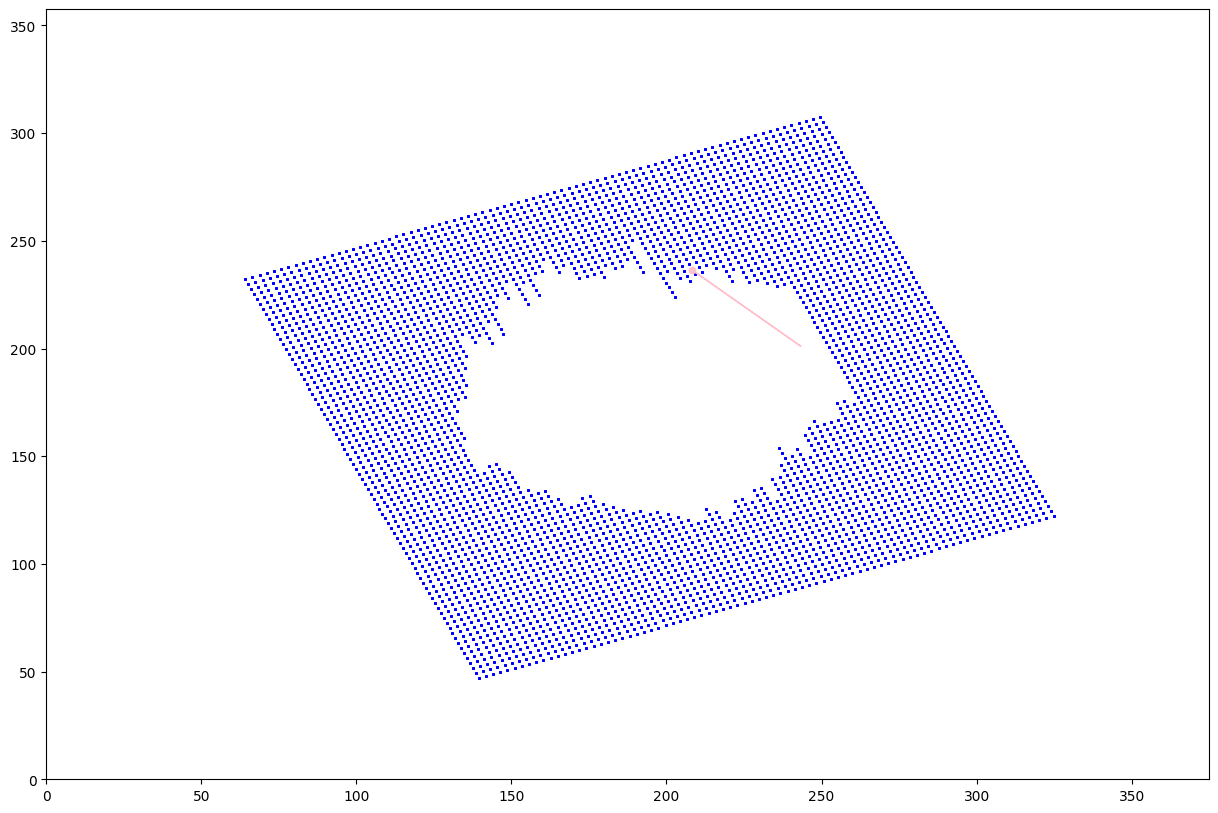

In [55]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [56]:
real_data_train = SonarDescriptorOnlyRealDataset()
real_data_valid = SonarDescriptorOnlyRealDataset(real_data_train)

In [57]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████████| 710/710 [00:09<00:00, 74.22it/s]

descriptors computed!


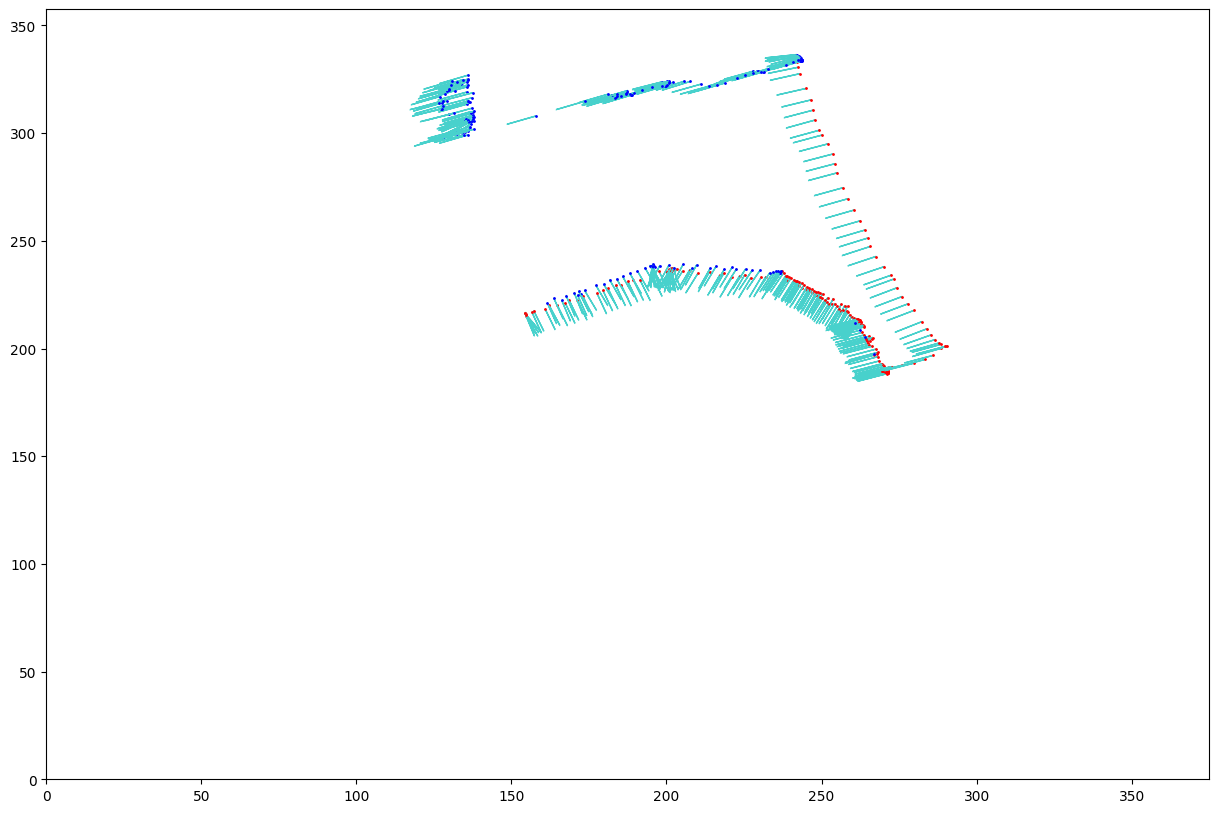

In [58]:
start_plot(train_data)
train_data.apply_random_rot = False

for i in range(0, 300, 5):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)
    plt.scatter(real_data.poses[i, 0], real_data.poses[i, 1], c="red", marker='o', linestyle='None', s =1)

for i in range(300, 710, 2):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)
    plt.scatter(real_data.poses[i, 0], real_data.poses[i, 1], c="red", marker='o', linestyle='None', s =1) 

for i in range(710, 900, 2):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)
    plt.scatter(real_data.poses[i, 0], real_data.poses[i, 1], c="blue", marker='o', linestyle='None', s =1)

for i in range(900, 1200, 5):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)
    plt.scatter(real_data.poses[i, 0], real_data.poses[i, 1], c="blue", marker='o', linestyle='None', s =1)  

for i in range(1200, 1500, 5):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)
    plt.scatter(real_data.poses[i, 0], real_data.poses[i, 1], c="blue", marker='o', linestyle='None', s =1)

iou: 0.9378777140044264
localization error: 0.0605 meters
orientation error : 0.0860 degrees


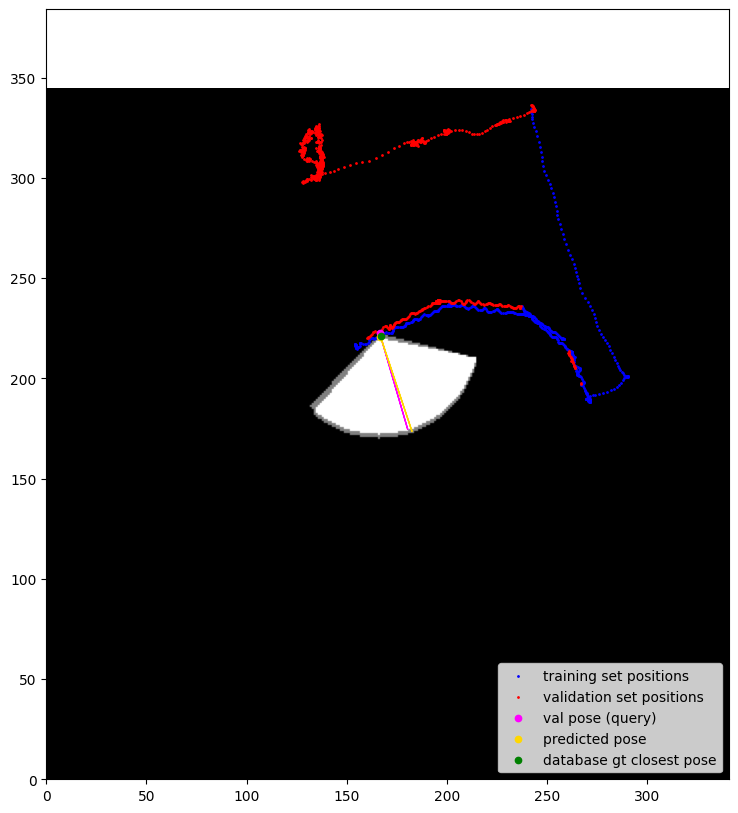

<Figure size 640x480 with 0 Axes>

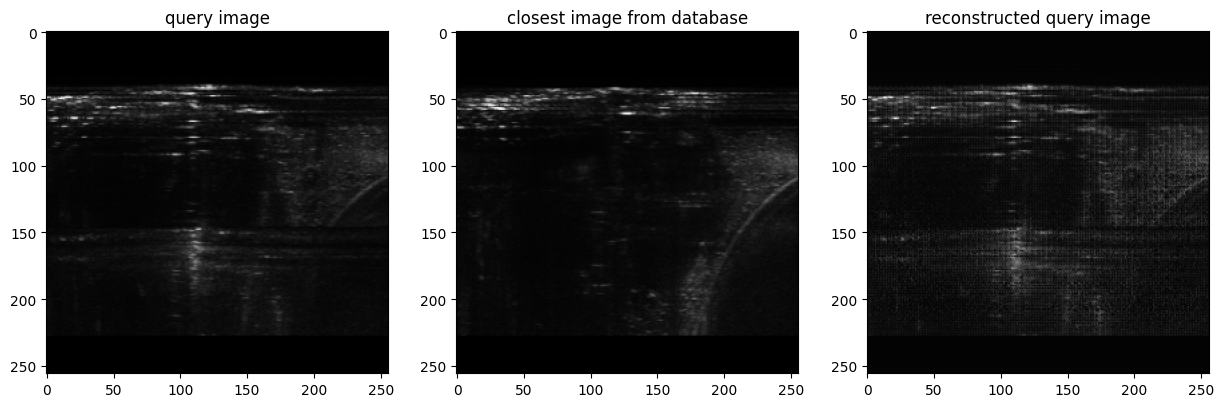

In [59]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = processReal(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [60]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = processReal(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

100%|█████████████████████████████████████████| 785/785 [00:19<00:00, 39.78it/s]

average localization error: 4.9823 meters
average orientation error : 30.6011 degrees


In [ ]:
avg_orie_error.min()

## K-TOP

In [ ]:
K = 15
bests = database.norms.argsort()

preds = np.zeros((K, 2))
imgs = []
for i in range(K):
    _, img, minpos, _, _, _ = database.dataset[bests[i]]
    preds[i, :] = minpos[:2]
    imgs.append(img)

colors = []
for v in database.norms/database.norms.max():
    colors.append([v, 0, 0])
    
plt.scatter(train_data.poses[:train_data.synth, 0], train_data.poses[:train_data.synth, 1], c=colors, marker='o', linestyle='None', s = 1)
plt.scatter(query_gtpose[0].item(), query_gtpose[1].item(), c='green',s = 20.51, label="gt query pose")
plt.scatter(preds[:, 0], preds[:, 1], c='blue', s = 20.51, label=f"database predicted {K} closest poses")
plt.legend(loc="lower right")

plt.figure()

f, axarr = plt.subplots(K, 2, figsize=(20, 20))

axarr[0,0].set_title(f"query image")
axarr[0,1].set_title(f"retrieved image")


for i in range(K):

    axarr[i,0].imshow(query_real_image.detach().cpu().numpy()[0, :, :], cmap='gray')
    axarr[i,1].imshow(imgs[i].numpy()[0, :, :], cmap='gray')